In [1]:
import math
import time
import warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.inspection import permutation_importance
from sklearn.ensemble import RandomForestRegressor
from xgboost import XGBRegressor, plot_importance
import optuna
from sklearn.metrics import mean_squared_error, mean_absolute_error
warnings.filterwarnings('ignore')

In [2]:
data = pd.read_csv(r'Z:\Research\Data 1\10-Site_SS-PV1-DB-SS-1A.csv')


In [3]:
data.isnull().sum()

timestamp                               0
Current_Phase_Average_Mean          27532
Active_Energy_Delivered_Received    26463
Active_Power                        27513
Wind_Speed                          64646
Weather_Temperature_Celsius         64657
Global_Horizontal_Radiation         64646
Wind_Direction                      64646
Weather_Daily_Rainfall              64646
Max_Wind_Speed                      64646
Air_Pressure                        64646
Hail_Accumulation                   64646
Pyranometer_1                       64646
Temperature_Probe_1                 64646
Temperature_Probe_2                 64646
dtype: int64

In [4]:
data.duplicated().sum()

np.int64(0)

### Filling And Droping NULLS

In [5]:
cols_with_many_nulls = [
    'Wind_Speed',
    'Weather_Temperature_Celsius',
    'Global_Horizontal_Radiation',
    'Wind_Direction',
    'Weather_Daily_Rainfall',
    'Max_Wind_Speed',
    'Air_Pressure',
    'Hail_Accumulation',
    'Pyranometer_1',
    'Temperature_Probe_1',
    'Temperature_Probe_2'
]
data = data.dropna(subset=cols_with_many_nulls)

cols = [
    'Current_Phase_Average_Mean',
    'Active_Energy_Delivered_Received',
    'Active_Power'
]

means = data[cols].mean(skipna=True)
data[cols] = data[cols].fillna(means)



In [6]:
data['timestamp'] = pd.to_datetime(data['timestamp'], errors='coerce')

# Keep ONLY rows where month is 1, 4, 7, or 10
data = data[data['timestamp'].dt.month.isin([11])]

# Reset index to start from 0 after filtering
data = data.reset_index(drop=True)

In [7]:
data

,timestamp,Current_Phase_Average_Mean,Active_Energy_Delivered_Received,Active_Power,Wind_Speed,Weather_Temperature_Celsius,Global_Horizontal_Radiation,Wind_Direction,Weather_Daily_Rainfall,Max_Wind_Speed,Air_Pressure,Hail_Accumulation,Pyranometer_1,Temperature_Probe_1,Temperature_Probe_2
0,2016-11-01 00:00:00,1.139145,1.799754e+05,-0.055549,2.620000,20.673334,-2.065835,150.333328,0.0,5.0,956.400024,0.0,-1.875866,38.086754,37.976578
1,2016-11-01 00:05:00,1.140124,1.799754e+05,-0.053785,2.740000,20.573334,-2.196234,151.899994,0.0,4.3,956.330017,0.0,-1.962318,38.030621,37.930344
2,2016-11-01 00:10:00,1.136632,1.799754e+05,-0.054641,2.830000,20.500000,-2.154061,149.433334,0.0,4.2,956.273315,0.0,-1.954115,37.962467,37.871494
3,2016-11-01 00:15:00,1.140058,1.799754e+05,-0.055462,2.380000,20.500000,-2.010609,140.633331,0.0,3.9,956.200012,0.0,-1.825062,37.945930,37.844826
4,2016-11-01 00:20:00,1.141346,1.799754e+05,-0.055605,2.723333,20.500000,-1.843456,145.000000,0.0,5.0,956.196655,0.0,-1.697256,37.909584,37.810932
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
69260,2024-11-30 23:35:00,0.969390,3.084020e+06,-0.049313,0.666667,28.756666,-3.196007,222.166672,0.0,1.1,948.900024,0.0,-2.729954,41.523457,41.267242
69261,2024-11-30 23:40:00,0.970789,3.084020e+06,-0.049277,0.526667,28.640001,-3.183723,224.500000,0.0,1.1,948.886658,0.0,-2.794706,41.516029,41.274822
69262,2024-11-30 23:45:00,0.971838,3.084020e+06,-0.049241,0.816667,28.520000,-2.988830,215.766663,0.0,1.3,948.803345,0.0,-2.632504,41.548428,41.296165
69263,2024-11-30 23:50:00,0.972252,3.084020e+06,-0.049265,0.830000,28.366667,-2.912630,189.899994,0.0,1.1,948.766663,0.0,-2.567473,41.586555,41.324978


### Droping Unrelated Colums

In [8]:
# Assuming 'Current_Phase_Average_Mean' is your target variable
target_correlations = data.drop(columns=['timestamp']).corr()['Current_Phase_Average_Mean']

# Keep only columns with positive correlation to target AND meaningful magnitude
positive_corr_columns = target_correlations[target_correlations > 0].index.tolist()

# Also apply your manual drop list
columns_to_drop = [
    'Wind_Speed', 'Weather_Temperature_Celsius', 'Wind_Direction',
    'Weather_Daily_Rainfall', 'Max_Wind_Speed', 'Air_Pressure',
    'Hail_Accumulation'
]

# Final list: positive correlations minus columns to manually drop
final_columns = [col for col in positive_corr_columns if col not in columns_to_drop]

data = data[final_columns]

print("Columns with positive correlation to target:")
for col in final_columns:
    print(f"{col}: {target_correlations[col]:.3f}")

Columns with positive correlation to target:
Current_Phase_Average_Mean: 1.000
Active_Power: 1.000
Global_Horizontal_Radiation: 0.802
Pyranometer_1: 0.798
Temperature_Probe_1: 0.750
Temperature_Probe_2: 0.758


In [9]:
data

,Current_Phase_Average_Mean,Active_Power,Global_Horizontal_Radiation,Pyranometer_1,Temperature_Probe_1,Temperature_Probe_2
0,1.139145,-0.055549,-2.065835,-1.875866,38.086754,37.976578
1,1.140124,-0.053785,-2.196234,-1.962318,38.030621,37.930344
2,1.136632,-0.054641,-2.154061,-1.954115,37.962467,37.871494
3,1.140058,-0.055462,-2.010609,-1.825062,37.945930,37.844826
4,1.141346,-0.055605,-1.843456,-1.697256,37.909584,37.810932
...,...,...,...,...,...,...
69260,0.969390,-0.049313,-3.196007,-2.729954,41.523457,41.267242
69261,0.970789,-0.049277,-3.183723,-2.794706,41.516029,41.274822
69262,0.971838,-0.049241,-2.988830,-2.632504,41.548428,41.296165
69263,0.972252,-0.049265,-2.912630,-2.567473,41.586555,41.324978


### Split Data

In [10]:
X = data.drop(columns=["Active_Power"])
y = data["Active_Power"]
X = X.select_dtypes(include=['number'])
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [11]:
#Data scale
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### XGBOOST Grid Search

In [13]:
xgb_model = XGBRegressor(
    subsample=0.8,
    colsample_bytree=0.8,
    random_state=42
)

# Hyperparameter grid
param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.05, 0.1, 1],
    'gamma': [0, 0.1, 0.3],
    'min_child_weight': [1, 3, 5, 7]
}

# Grid search
grid_search = GridSearchCV(
    estimator=xgb_model,
    param_grid=param_grid,
    scoring='r2',
    cv=5,
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train_scaled, y_train)
# Predictions
y_train_predxg = grid_search.predict(X_train_scaled)
y_test_predxg = grid_search.predict(X_test_scaled)

Fitting 5 folds for each of 720 candidates, totalling 3600 fits


Train R²: 0.9998
Test R²: 0.9997
Best Score: 0.9996712861924841
Best Parameters: {'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 5, 'min_child_weight': 7, 'n_estimators': 500}

--- Additional Metrics ---
Train MSE: 0.7483, Test MSE: 0.9674
Train RMSE: 0.8650, Test RMSE: 0.9836
Train MAE: 0.4119, Test MAE: 0.4605
Train MAPE: 46084216.05%, Test MAPE: 47441456.78%
Execution Time: 0.20 seconds

Feature Importance (by weight):
{'f0': 3539.0, 'f1': 2631.0, 'f2': 2725.0, 'f3': 1894.0, 'f4': 2350.0}


<Figure size 1000x600 with 0 Axes>

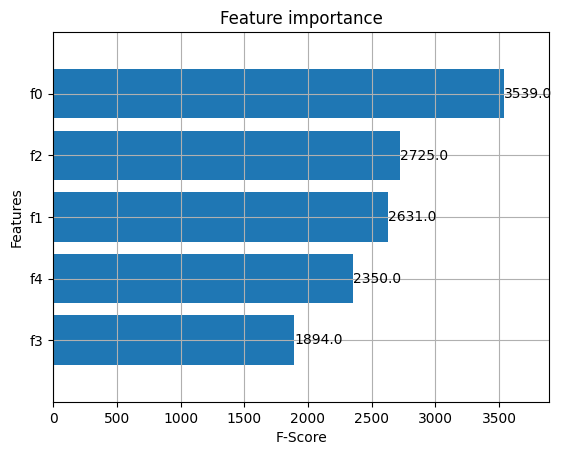

In [14]:
start_time = time.time()

y_train_predxg = grid_search.predict(X_train_scaled)
y_test_predxg = grid_search.predict(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

train_r2 = r2_score(y_train, y_train_predxg)
test_r2 = r2_score(y_test, y_test_predxg)

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")

print("Best Score:", grid_search.best_score_)
print("Best Parameters:", grid_search.best_params_)

train_mse = mean_squared_error(y_train, y_train_predxg)
test_mse = mean_squared_error(y_test, y_test_predxg)

train_rmse = np.sqrt(train_mse)
test_rmse = np.sqrt(test_mse)

train_mae = mean_absolute_error(y_train, y_train_predxg)
test_mae = mean_absolute_error(y_test, y_test_predxg)

train_mape = np.mean(np.abs((y_train - y_train_predxg) / np.maximum(y_train, 1e-8))) * 100
test_mape = np.mean(np.abs((y_test - y_test_predxg) / np.maximum(y_test, 1e-8))) * 100

print("\n--- Additional Metrics ---")
print(f"Train MSE: {train_mse:.4f}, Test MSE: {test_mse:.4f}")
print(f"Train RMSE: {train_rmse:.4f}, Test RMSE: {test_rmse:.4f}")
print(f"Train MAE: {train_mae:.4f}, Test MAE: {test_mae:.4f}")
print(f"Train MAPE: {train_mape:.2f}%, Test MAPE: {test_mape:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

best_model = grid_search.best_estimator_

importance = best_model.get_booster().get_score(importance_type="weight")
print("\nFeature Importance (by weight):")
print(importance)

plt.figure(figsize=(10, 6))
plot_importance(best_model, importance_type="weight", xlabel="F-Score", height=0.8)
plt.show()


### Optmizer XGBoost

In [15]:
scaler_X = StandardScaler()
X_train_scaled = scaler_X.fit_transform(X_train)
X_test_scaled = scaler_X.transform(X_test)

scale_y = False
if scale_y:
    scaler_y = StandardScaler()
    y_train_scaled = scaler_y.fit_transform(y_train.values.reshape(-1,1)).flatten()
    y_test_scaled = scaler_y.transform(y_test.values.reshape(-1,1)).flatten()
else:
    y_train_scaled = y_train.values
    y_test_scaled = y_test.values

def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 50, 500)
    max_depth = trial.suggest_int("max_depth", 3, 20)
    learning_rate = trial.suggest_float("learning_rate", 0.01, 0.3, log=True)
    gamma = trial.suggest_float("gamma", 0, 5)
    min_child_weight = trial.suggest_int("min_child_weight", 1, 10)
    subsample = trial.suggest_float("subsample", 0.5, 1.0)
    colsample_bytree = trial.suggest_float("colsample_bytree", 0.5, 1.0)

    model = XGBRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        learning_rate=learning_rate,
        gamma=gamma,
        min_child_weight=min_child_weight,
        subsample=subsample,
        colsample_bytree=colsample_bytree,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train_scaled, y_train_scaled)
    y_pred = model.predict(X_test_scaled)
    return mean_squared_error(y_test_scaled, y_pred)

start_opt_time = time.time()
study = optuna.create_study(direction="minimize", sampler=optuna.samplers.TPESampler())
study.optimize(objective, n_trials=50)
end_opt_time = time.time()
optimization_time = end_opt_time - start_opt_time
best_params = study.best_params

final_model = XGBRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    learning_rate=best_params["learning_rate"],
    gamma=best_params["gamma"],
    min_child_weight=best_params["min_child_weight"],
    subsample=best_params["subsample"],
    colsample_bytree=best_params["colsample_bytree"],
    random_state=42,
    n_jobs=-1
)

final_model.fit(X_train_scaled, y_train_scaled)

[I 2025-09-13 18:33:06,916] A new study created in memory with name: no-name-76212fa3-93aa-45b0-8169-29ac02b4f08e


[I 2025-09-13 18:33:12,545] Trial 0 finished with value: 22.997146107065635 and parameters: {'n_estimators': 298, 'max_depth': 16, 'learning_rate': 0.07094112397845433, 'gamma': 0.37483433746879624, 'min_child_weight': 9, 'subsample': 0.9443227484148718, 'colsample_bytree': 0.5166785323264906}. Best is trial 0 with value: 22.997146107065635.
[I 2025-09-13 18:33:13,134] Trial 1 finished with value: 2.738663079606471 and parameters: {'n_estimators': 80, 'max_depth': 10, 'learning_rate': 0.0756912013891578, 'gamma': 3.496333862734267, 'min_child_weight': 9, 'subsample': 0.9882824982282823, 'colsample_bytree': 0.9293246639130529}. Best is trial 1 with value: 2.738663079606471.
[I 2025-09-13 18:33:16,312] Trial 2 finished with value: 10.836983539640482 and parameters: {'n_estimators': 205, 'max_depth': 18, 'learning_rate': 0.0572869468015182, 'gamma': 4.025874956616756, 'min_child_weight': 2, 'subsample': 0.5870568900336759, 'colsample_bytree': 0.8443615338990447}. Best is trial 1 with valu

,objective,'reg:squarederror'
,base_score,None
,booster,None
,callbacks,None
,colsample_bylevel,None
,colsample_bynode,None
,colsample_bytree,0.8508097354662338
,device,None
,early_stopping_rounds,None
,enable_categorical,False
,eval_metric,None


In [16]:
start_pred_time = time.time()
y_pred_scaled = final_model.predict(X_test_scaled)
end_pred_time = time.time()
prediction_time = end_pred_time - start_pred_time

if scale_y:
    y_pred = scaler_y.inverse_transform(y_pred_scaled.reshape(-1,1)).flatten()
else:
    y_pred = y_pred_scaled

mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_pred)
mape = np.mean(np.abs((y_test - y_pred) / np.maximum(y_test, 1e-8))) * 100
r2 = r2_score(y_test, y_pred)

print("Best Parameters (Optuna):", best_params)
print(f"Optimization Time: {optimization_time:.2f} seconds")
print(f"Prediction Time: {prediction_time:.2f} seconds")
print(f"R²: {r2:.4f}")
print(f"MSE: {mse:.4f}")
print(f"RMSE: {rmse:.4f}")
print(f"MAE: {mae:.4f}")
print(f"MAPE: {mape:.2f}%")

Best Parameters (Optuna): {'n_estimators': 183, 'max_depth': 6, 'learning_rate': 0.1782417522478998, 'gamma': 3.4363142015395987, 'min_child_weight': 10, 'subsample': 0.6291499140025437, 'colsample_bytree': 0.8508097354662338}
Optimization Time: 42.95 seconds
Prediction Time: 0.03 seconds
R²: 0.9997
MSE: 1.0172
RMSE: 1.0086
MAE: 0.4901
MAPE: 84704509.28%


### Optmizer Random Forest

In [17]:
#Bayesian Optimizer (TPE sampler)
def objective(trial):
    n_estimators = trial.suggest_int("n_estimators", 10, 200)
    max_depth = trial.suggest_int("max_depth", 1, 20)

    model = RandomForestRegressor(
        n_estimators=n_estimators,
        max_depth=max_depth,
        random_state=42,
        n_jobs=-1
    )
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)

    return mean_squared_error(y_test, y_pred)


study = optuna.create_study(direction="minimize")
study.optimize(objective, n_trials=30)


best_params = study.best_params
final_model = RandomForestRegressor(
    n_estimators=best_params["n_estimators"],
    max_depth=best_params["max_depth"],
    random_state=42,
    n_jobs=-1
)
final_model.fit(X_train, y_train)

[I 2025-09-13 18:33:50,353] A new study created in memory with name: no-name-307ad819-3b2d-4c9f-86ec-9215ffa35557
[I 2025-09-13 18:33:50,851] Trial 0 finished with value: 1.5162197786287528 and parameters: {'n_estimators': 12, 'max_depth': 6}. Best is trial 0 with value: 1.5162197786287528.
[I 2025-09-13 18:33:55,670] Trial 1 finished with value: 0.8314032675110652 and parameters: {'n_estimators': 71, 'max_depth': 14}. Best is trial 1 with value: 0.8314032675110652.
[I 2025-09-13 18:34:06,117] Trial 2 finished with value: 0.8358350368186767 and parameters: {'n_estimators': 116, 'max_depth': 20}. Best is trial 1 with value: 0.8314032675110652.
[I 2025-09-13 18:34:08,878] Trial 3 finished with value: 0.7905347223989514 and parameters: {'n_estimators': 55, 'max_depth': 9}. Best is trial 3 with value: 0.7905347223989514.
[I 2025-09-13 18:34:24,129] Trial 4 finished with value: 0.8280792927618245 and parameters: {'n_estimators': 184, 'max_depth': 18}. Best is trial 3 with value: 0.790534722

,n_estimators,165
,criterion,'squared_error'
,max_depth,10
,min_samples_split,2
,min_samples_leaf,1
,min_weight_fraction_leaf,0.0
,max_features,1.0
,max_leaf_nodes,None
,min_impurity_decrease,0.0
,bootstrap,True
,oob_score,False


In [18]:
start_time = time.time()

y_predoprf = final_model.predict(X_test)

end_time = time.time()
elapsed_time = end_time - start_time

mse = mean_squared_error(y_test, y_predoprf)
rmse = np.sqrt(mse)  # works regardless of sklearn version
mae = mean_absolute_error(y_test, y_predoprf)
mape = np.mean(np.abs((y_test - y_predoprf) / np.maximum(y_test, 1e-8))) * 100
r2 = r2_score(y_test, y_predoprf)

print("Best Params (Optuna):", best_params)
print(f"Test R²: {r2:.4f}")
print(f"Test MSE: {mse:.4f}")
print(f"Test RMSE: {rmse:.4f}")
print(f"Test MAE: {mae:.4f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

Best Params (Optuna): {'n_estimators': 165, 'max_depth': 10}
Test R²: 0.9998
Test MSE: 0.7753
Test RMSE: 0.8805
Test MAE: 0.3441
Test MAPE: 6883460.41%
Execution Time: 0.18 seconds


### RF RANDOM SEARCH

In [19]:
#RandomizedSearchCV
rf_model = RandomForestRegressor(random_state=42, n_jobs=-1)

param_grid = {
    'n_estimators': [100, 200, 300, 400, 500],
    'max_depth': [None, 5, 10, 20],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

random_search = RandomizedSearchCV(
    estimator=rf_model,
    param_distributions=param_grid,
    n_iter=10,
    scoring='r2',
    cv=3,
    verbose=1,
    n_jobs=-1,
    random_state=42
)

random_search.fit(X_train_scaled, y_train)

Fitting 3 folds for each of 10 candidates, totalling 30 fits


,estimator,RandomForestR...ndom_state=42)
,param_distributions,"{'max_depth': [None, 5, ...], 'min_samples_leaf': [1, 2, ...], 'min_samples_split': [2, 5, ...], 'n_estimators': [100, 200, ...]}"
,n_iter,10
,scoring,'r2'
,n_jobs,-1
,refit,True
,cv,3
,verbose,1
,pre_dispatch,'2*n_jobs'
,random_state,42
,error_score,nan


Train R²: 0.9999
Test R²: 0.9998
Best Score (CV): 0.9997399564625219
Best Parameters: {'n_estimators': 300, 'min_samples_split': 10, 'min_samples_leaf': 4, 'max_depth': None}
Test MSE:  0.777278
Test RMSE: 0.881634
Test MAE:  0.333341
Test MAPE: 4064031.01%
Execution Time: 0.84 seconds


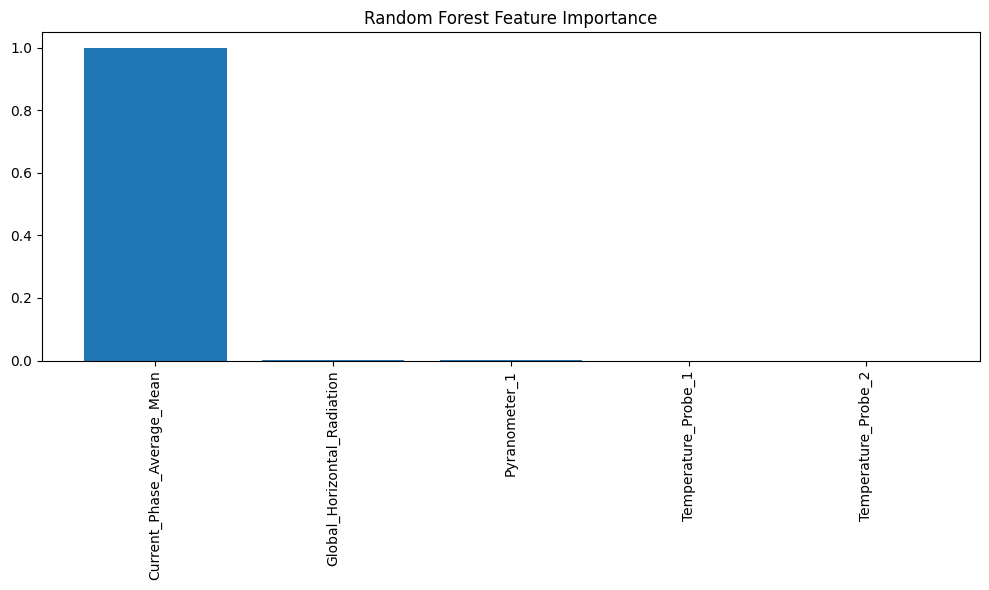

In [20]:
start_time = time.time()

y_train_pred_rf_random = random_search.predict(X_train_scaled)
y_test_pred_rf_random = random_search.predict(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

train_r2 = r2_score(y_train, y_train_pred_rf_random)
test_r2 = r2_score(y_test, y_test_pred_rf_random)

mse = mean_squared_error(y_test, y_test_pred_rf_random)
rmse = np.sqrt(mse)
mae = mean_absolute_error(y_test, y_test_pred_rf_random)
mape = np.mean(np.abs((y_test - y_test_pred_rf_random) / np.maximum(y_test, 1e-8))) * 100

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²: {test_r2:.4f}")
print("Best Score (CV):", random_search.best_score_)
print("Best Parameters:", random_search.best_params_)
print(f"Test MSE:  {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE:  {mae:.6f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

best_model = random_search.best_estimator_

importances = best_model.feature_importances_
indices = np.argsort(importances)[::-1]
feature_names = X_train.columns

plt.figure(figsize=(10, 6))
plt.title("Random Forest Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), feature_names[indices], rotation=90)
plt.tight_layout()
plt.show()

### CatBoost with grid search

In [12]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import GridSearchCV
from catboost import CatBoostRegressor

start_time = time.time()

param_grid = {
    "depth": [4, 6, 8],
    "learning_rate": [0.01, 0.05, 0.1],
    "iterations": [200, 500],
    "l2_leaf_reg": [1, 3, 5]
}

cat_model = CatBoostRegressor(
    silent=True,
    random_state=42
)

grid_search = GridSearchCV(
    estimator=cat_model,
    param_grid=param_grid,
    scoring="r2",
    cv=3,
    n_jobs=-1,
    verbose=1
)

grid_search.fit(X_train_scaled, y_train)

end_time = time.time()
elapsed_time = end_time - start_time
best_model = grid_search.best_estimator_

Fitting 3 folds for each of 54 candidates, totalling 162 fits



CatBoost Model Results (Grid Search)
Best Parameters: {'depth': 8, 'iterations': 500, 'l2_leaf_reg': 1, 'learning_rate': 0.1}
Train R²: 0.9998
Test R²:  0.9997
Test MSE:  0.915469
Test RMSE: 0.956801
Test MAE:  0.442871
Test MAPE: 79188120.66%
Execution Time: 436.89 seconds


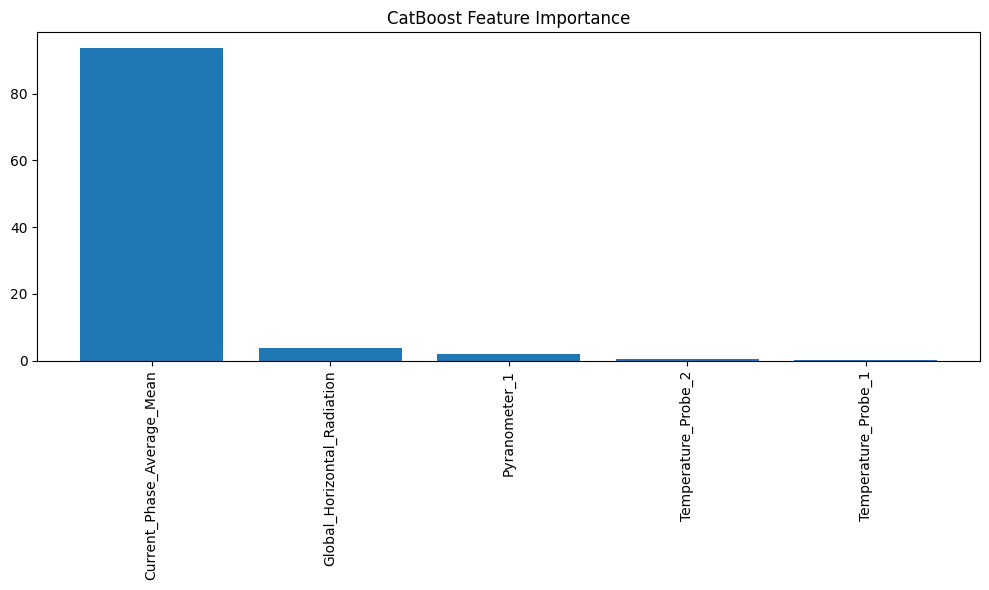

In [13]:
y_train_pred_cat = best_model.predict(X_train_scaled)
y_test_pred_cat = best_model.predict(X_test_scaled)

train_r2 = r2_score(y_train, y_train_pred_cat)
test_r2 = r2_score(y_test, y_test_pred_cat)

mse_test = mean_squared_error(y_test, y_test_pred_cat)
rmse_test = np.sqrt(mse_test) # Calculate RMSE manually
mae_test = mean_absolute_error(y_test, y_test_pred_cat)
mape_test = np.mean(np.abs((y_test - y_test_pred_cat) / np.maximum(y_test, 1e-8))) * 100

print("\nCatBoost Model Results (Grid Search)")
print("Best Parameters:", grid_search.best_params_)
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

importances = best_model.get_feature_importance()
indices = np.argsort(importances)[::-1]

plt.figure(figsize=(10, 6))
plt.title("CatBoost Feature Importance")
plt.bar(range(X_train.shape[1]), importances[indices], align="center")
plt.xticks(range(X_train.shape[1]), X_train.columns[indices], rotation=90)
plt.tight_layout()
plt.show()

### IHO-ELM

In [23]:
class ELM:
    def __init__(self, n_input, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.activation = activation
        self.rng = np.random.RandomState(random_state)
        self.Win = None
        self.bias = None
        self.beta = None

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            return x

    def fit(self, X, y, C=1.0, seed=None):
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        n_samples, n_input = X.shape
        y = y.reshape(-1, 1)

        # random input weights and biases
        self.Win = self.rng.uniform(-1, 1, size=(n_input, self.n_hidden))
        self.bias = self.rng.uniform(-1, 1, size=(self.n_hidden,))

        H = self._activation(X.dot(self.Win) + self.bias)
        I = np.eye(self.n_hidden)
        A = H.T.dot(H) + I / C
        B = H.T.dot(y)
        self.beta = np.linalg.solve(A, B)

    def predict(self, X):
        H = self._activation(X.dot(self.Win) + self.bias)
        return H.dot(self.beta).ravel()

# ======================================================
# IHO optimizer (simplified for regression)
# ======================================================
def levy_flight(Lambda):
    sigma = (math.gamma(1 + Lambda) * math.sin(math.pi * Lambda / 2) /
             (math.gamma((1 + Lambda) / 2) * Lambda * 2 ** ((Lambda - 1) / 2))) ** (1 / Lambda)
    u = np.random.normal(0, sigma, size=1)
    v = np.random.normal(0, 1, size=1)
    return (u / abs(v) ** (1 / Lambda))[0]

def IHO_optimize(fitness_fn, lb, ub, dim, population=20, max_iter=50, seed=None):
    rng = np.random.RandomState(seed)
    X = rng.uniform(lb, ub, (population, dim))
    fitness = np.array([fitness_fn(x) for x in X])
    best_idx = np.argmin(fitness)
    X_best, f_best = X[best_idx].copy(), fitness[best_idx]

    for t in range(1, max_iter + 1):
        E1 = 2 * (1 - t / max_iter)
        for i in range(population):
            E0 = 2 * rng.rand() - 1
            E = E1 * E0
            q = rng.rand()
            X_i = X[i].copy()

            if abs(E) >= 1:  # exploration
                rand_hawk = X[rng.randint(population)]
                X_new = rand_hawk - rng.rand() * abs(rand_hawk - 2 * rng.rand() * X_i)
                if rng.rand() < 0.3:
                    X_new += levy_flight(1.5) * (X_new - X_best)
            else:  # exploitation
                if q < 0.5:
                    X_new = X_best - E * abs(X_best - X_i)
                else:
                    X_new = X_best - E * (abs(X_best - X_i) + rng.rand() * (X_best - X_i))

            X_new = np.clip(X_new, lb, ub)
            f_new = fitness_fn(X_new)
            if f_new < fitness[i]:
                X[i], fitness[i] = X_new, f_new
            if f_new < f_best:
                X_best, f_best = X_new.copy(), f_new

    return X_best, f_best

# ======================================================
# Fitness function for regression
# ======================================================
def make_elm_fitness(X_train, y_train, X_val, y_val, input_dim, seed=None):
    def fitness_fn(pos):
        n_hidden = int(np.round(pos[0])); n_hidden = max(5, n_hidden)
        log10_C = pos[1]; C = 10 ** log10_C
        elm = ELM(n_input=input_dim, n_hidden=n_hidden, activation='sigmoid', random_state=seed)
        try:
            elm.fit(X_train, y_train, C=C, seed=seed)
            y_pred = elm.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
        except Exception:
            mse = 1e6
        return mse
    return fitness_fn

In [24]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

lb = np.array([10, -3.0])
ub = np.array([200, 3.0])
dim = 2

fitness = make_elm_fitness(X_tr, y_tr.values, X_val, y_val.values, input_dim=X.shape[1], seed=42)

start = time.time()
best_pos, best_fit = IHO_optimize(fitness, lb, ub, dim, population=25, max_iter=60, seed=42)
elapsed = time.time() - start

n_hidden_best = int(np.round(best_pos[0]))
C_best = 10 ** best_pos[1]

print("\nBest hyperparameters found:")
print(f" - Hidden neurons: {n_hidden_best}")
print(f" - C: {C_best:.4f}")
print(f"Validation MSE: {best_fit:.6f}")
print(f"Optimization time: {elapsed:.2f}s")

elm_final = ELM(n_input=X.shape[1], n_hidden=n_hidden_best, activation='sigmoid', random_state=42)
elm_final.fit(X_train_scaled, y_train.values, C=C_best, seed=42)


Best hyperparameters found:
 - Hidden neurons: 198
 - C: 958.1851
Validation MSE: 1.295025
Optimization time: 293.05s


In [25]:
start_time = time.time()

y_test_prediho = elm_final.predict(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

mse = mean_squared_error(y_test, y_test_prediho)
rmse = np.sqrt(mse)  # safe RMSE calculation
mae = mean_absolute_error(y_test, y_test_prediho)
mape = np.mean(np.abs((y_test - y_test_prediho) / np.maximum(y_test, 1e-8))) * 100
r2 = r2_score(y_test, y_test_prediho)

print(f"\nTest R²:  {r2:.4f}")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")


Test R²:  0.9997
Test MSE: 1.197263
Test RMSE: 1.094195
Test MAE: 0.581196
Test MAPE: 447198944.12%
Execution Time: 0.09 seconds


### HO-ELM

In [26]:
class ELM:
    def __init__(self, n_input, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.activation = activation
        self.rng = np.random.RandomState(random_state)
        self.Win = None
        self.bias = None
        self.beta = None

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            return x

    def fit(self, X, y, C=1.0, seed=None):
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        n_samples, n_input = X.shape
        y = y.reshape(-1, 1)

        # random input weights and biases
        self.Win = self.rng.uniform(-1, 1, size=(n_input, self.n_hidden))
        self.bias = self.rng.uniform(-1, 1, size=(self.n_hidden,))

        H = self._activation(X.dot(self.Win) + self.bias)
        I = np.eye(self.n_hidden)
        A = H.T.dot(H) + I / C
        B = H.T.dot(y)
        self.beta = np.linalg.solve(A, B)

    def predict(self, X):
        H = self._activation(X.dot(self.Win) + self.bias)
        return H.dot(self.beta).ravel()

# ======================================================
# Harris Hawks Optimization (HO / HHO)
# ======================================================
def HO_optimize(fitness_fn, lb, ub, dim, population=20, max_iter=50, seed=None):
    rng = np.random.RandomState(seed)
    X = rng.uniform(lb, ub, (population, dim))
    fitness = np.array([fitness_fn(x) for x in X])
    best_idx = np.argmin(fitness)
    X_best, f_best = X[best_idx].copy(), fitness[best_idx]

    for t in range(1, max_iter + 1):
        E1 = 2 * (1 - t / max_iter)  # escaping energy decreases with iterations
        for i in range(population):
            E0 = 2 * rng.rand() - 1
            E = E1 * E0
            q = rng.rand()
            r = rng.rand()
            X_i = X[i].copy()

            if abs(E) >= 1:  # exploration
                rand_hawk = X[rng.randint(population)]
                X_new = rand_hawk - rng.rand() * abs(rand_hawk - 2 * rng.rand() * X_i)
            else:  # exploitation
                if q < 0.5:
                    X_new = X_best - E * abs(X_best - X_i)
                else:
                    X_new = X_best - E * (abs(X_best - X_i) + rng.rand() * (X_best - X_i))

            X_new = np.clip(X_new, lb, ub)
            f_new = fitness_fn(X_new)
            if f_new < fitness[i]:
                X[i], fitness[i] = X_new, f_new
            if f_new < f_best:
                X_best, f_best = X_new.copy(), f_new

    return X_best, f_best

# ======================================================
# Fitness function for regression
# ======================================================
def make_elm_fitness(X_train, y_train, X_val, y_val, input_dim, seed=None):
    def fitness_fn(pos):
        n_hidden = int(np.round(pos[0])); n_hidden = max(5, n_hidden)
        log10_C = pos[1]; C = 10 ** log10_C
        elm = ELM(n_input=input_dim, n_hidden=n_hidden, activation='sigmoid', random_state=seed)
        try:
            elm.fit(X_train, y_train, C=C, seed=seed)
            y_pred = elm.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
        except Exception:
            mse = 1e6
        return mse
    return fitness_fn

In [27]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

lb = np.array([10, -3.0])   # min hidden neurons, min log10(C)
ub = np.array([200, 3.0])   # max hidden neurons, max log10(C)
dim = 2

fitness = make_elm_fitness(X_tr, y_tr.values, X_val, y_val.values, input_dim=X.shape[1], seed=42)

start = time.time()
best_pos, best_fit = HO_optimize(fitness, lb, ub, dim, population=25, max_iter=60, seed=42)
elapsed = time.time() - start

n_hidden_best = int(np.round(best_pos[0]))
C_best = 10 ** best_pos[1]

print("\nBest hyperparameters found by HO:")
print(f" - Hidden neurons: {n_hidden_best}")
print(f" - C: {C_best:.4f}")
print(f"Validation MSE: {best_fit:.6f}")
print(f"Optimization time: {elapsed:.2f}s")

elm_final = ELM(n_input=X.shape[1], n_hidden=n_hidden_best, activation='sigmoid', random_state=42)
elm_final.fit(X_train_scaled, y_train.values, C=C_best, seed=42)


Best hyperparameters found by HO:
 - Hidden neurons: 198
 - C: 1000.0000
Validation MSE: 1.293761
Optimization time: 295.38s


In [28]:
start_time = time.time()

y_test_predho = elm_final.predict(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

mse = mean_squared_error(y_test, y_test_predho)
rmse = np.sqrt(mse)  # manual RMSE
mae = mean_absolute_error(y_test, y_test_predho)
mape = np.mean(np.abs((y_test - y_test_predho) / np.maximum(y_test, 1e-8))) * 100
r2 = r2_score(y_test, y_test_predho)

print(f"\nTest R²:  {r2:.4f}")
print(f"Test MSE: {mse:.6f}")
print(f"Test RMSE: {rmse:.6f}")
print(f"Test MAE: {mae:.6f}")
print(f"Test MAPE: {mape:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")


Test R²:  0.9997
Test MSE: 1.196340
Test RMSE: 1.093773
Test MAE: 0.580755
Test MAPE: 446828777.41%
Execution Time: 0.09 seconds


### CSO-ELM

In [29]:
class ELM:
    def __init__(self, n_input, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.activation = activation
        self.rng = np.random.RandomState(random_state)
        self.Win = None
        self.bias = None
        self.beta = None

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            return x

    def fit(self, X, y, C=1.0, seed=None):
        if seed is not None:
            self.rng = np.random.RandomState(seed)
        y = y.reshape(-1, 1)

        self.Win = self.rng.uniform(-1, 1, size=(X.shape[1], self.n_hidden))
        self.bias = self.rng.uniform(-1, 1, size=(self.n_hidden,))

        H = self._activation(X.dot(self.Win) + self.bias)
        I = np.eye(self.n_hidden)
        A = H.T.dot(H) + I / C
        B = H.T.dot(y)
        self.beta = np.linalg.solve(A, B)

    def predict(self, X):
        H = self._activation(X.dot(self.Win) + self.bias)
        return H.dot(self.beta).ravel()

# ======================================================
# Cat Swarm Optimization (CSO)
# ======================================================
def CSO_optimize(fitness_fn, lb, ub, dim, pop_size=30, max_iter=50, mr=0.2, smp=5, c=2.0, seed=None):
    """
    - fitness_fn: fitness function
    - lb, ub: lower & upper bounds (array)
    - dim: dimensions
    - pop_size: number of cats
    - mr: mixture ratio (percentage in tracing mode)
    - smp: seeking memory pool size
    - c: learning coefficient in tracing mode
    """
    rng = np.random.RandomState(seed)
    cats = rng.uniform(lb, ub, (pop_size, dim))
    fitness = np.array([fitness_fn(cat) for cat in cats])
    best_idx = np.argmin(fitness)
    best_cat, best_fit = cats[best_idx].copy(), fitness[best_idx]

    for it in range(max_iter):
        for i in range(pop_size):
            if rng.rand() > mr:  # Seeking mode (exploit)
                candidates = []
                for _ in range(smp):
                    cand = cats[i].copy()
                    j = rng.randint(dim)
                    cand[j] += rng.uniform(-0.2, 0.2) * cand[j]
                    cand = np.clip(cand, lb, ub)
                    candidates.append(cand)
                cand_fits = [fitness_fn(c) for c in candidates]
                best_cand = candidates[np.argmin(cand_fits)]
                cats[i] = best_cand
                fitness[i] = np.min(cand_fits)
            else:  # Tracing mode (explore)
                cats[i] = cats[i] + c * rng.rand(dim) * (best_cat - cats[i])
                cats[i] = np.clip(cats[i], lb, ub)
                fitness[i] = fitness_fn(cats[i])

            # update global best
            if fitness[i] < best_fit:
                best_cat, best_fit = cats[i].copy(), fitness[i]

    return best_cat, best_fit

# ======================================================
# Fitness function for regression
# ======================================================
def make_elm_fitness(X_train, y_train, X_val, y_val, input_dim, seed=None):
    def fitness_fn(pos):
        n_hidden = int(np.round(pos[0])); n_hidden = max(5, n_hidden)
        log10_C = pos[1]; C = 10 ** log10_C
        elm = ELM(n_input=input_dim, n_hidden=n_hidden, activation='sigmoid', random_state=seed)
        try:
            elm.fit(X_train, y_train, C=C, seed=seed)
            y_pred = elm.predict(X_val)
            mse = mean_squared_error(y_val, y_pred)
        except Exception:
            mse = 1e6
        return mse
    return fitness_fn

In [30]:
X_tr, X_val, y_tr, y_val = train_test_split(X_train_scaled, y_train, test_size=0.2, random_state=42)

# Bounds
lb = np.array([10, -3.0])   # hidden neurons, log10(C)
ub = np.array([200, 3.0])
dim = 2

fitness = make_elm_fitness(X_tr, y_tr.values, X_val, y_val.values, input_dim=X.shape[1], seed=42)

# Run CSO
start = time.time()
best_pos, best_fit = CSO_optimize(fitness, lb, ub, dim, pop_size=30, max_iter=60, mr=0.3, seed=42)
elapsed = time.time() - start

n_hidden_best = int(np.round(best_pos[0]))
C_best = 10 ** best_pos[1]

print("\nBest hyperparameters found by CSO:")
print(f" - Hidden neurons: {n_hidden_best}")
print(f" - C: {C_best:.4f}")
print(f"Validation MSE: {best_fit:.6f}")
print(f"Optimization time: {elapsed:.2f}s")

# Final model
elm_final = ELM(n_input=X.shape[1], n_hidden=n_hidden_best, activation='sigmoid', random_state=42)
elm_final.fit(X_train_scaled, y_train.values, C=C_best, seed=42)


Best hyperparameters found by CSO:
 - Hidden neurons: 198
 - C: 1000.0000
Validation MSE: 1.293761
Optimization time: 1292.46s


In [31]:
start_time = time.time()

y_test_predcso = elm_final.predict(X_test_scaled)

end_time = time.time()
elapsed_time = end_time - start_time

mse_test = mean_squared_error(y_test, y_test_predcso)
rmse_test = np.sqrt(mse_test)  # manual RMSE calculation
mae_test = mean_absolute_error(y_test, y_test_predcso)
mape_test = np.mean(np.abs((y_test - y_test_predcso) / np.maximum(y_test, 1e-8))) * 100
r2_test = r2_score(y_test, y_test_predcso)

print(f"\nTest MSE:   {mse_test:.6f}")
print(f"Test RMSE:  {rmse_test:.6f}")
print(f"Test MAE:   {mae_test:.6f}")
print(f"Test MAPE:  {mape_test:.2f}%")
print(f"Test R²:    {r2_test:.4f}")
print(f"Execution Time: {elapsed_time:.2f} seconds")



Test MSE:   1.196340
Test RMSE:  1.093773
Test MAE:   0.580755
Test MAPE:  446828777.41%
Test R²:    0.9997
Execution Time: 0.08 seconds


### ELM

In [32]:
class ELM:
    def __init__(self, n_input, n_hidden=50, activation='sigmoid', random_state=None):
        self.n_input = n_input
        self.n_hidden = n_hidden
        self.activation = activation
        self.rng = np.random.RandomState(random_state)
        self.Win = None
        self.bias = None
        self.beta = None

    def _activation(self, x):
        if self.activation == 'sigmoid':
            return 1.0 / (1.0 + np.exp(-x))
        elif self.activation == 'tanh':
            return np.tanh(x)
        elif self.activation == 'relu':
            return np.maximum(0, x)
        else:
            return x  # linear

    def fit(self, X, y, C=1.0):
        y = y.reshape(-1, 1)

        # random input weights & biases
        self.Win = self.rng.uniform(-1, 1, size=(X.shape[1], self.n_hidden))
        self.bias = self.rng.uniform(-1, 1, size=(self.n_hidden,))

        # hidden layer output
        H = self._activation(X.dot(self.Win) + self.bias)

        # compute output weights (ridge regression)
        I = np.eye(self.n_hidden)
        A = H.T.dot(H) + I / C
        B = H.T.dot(y)
        self.beta = np.linalg.solve(A, B)

    def predict(self, X):
        H = self._activation(X.dot(self.Win) + self.bias)
        return H.dot(self.beta).ravel()

Train R²: 0.9995
Test R²:  0.9995
Test MSE:  1.697212
Test RMSE: 1.302771
Test MAE:  0.786685
Test MAPE: 598704992.94%
Execution Time: 0.25 seconds


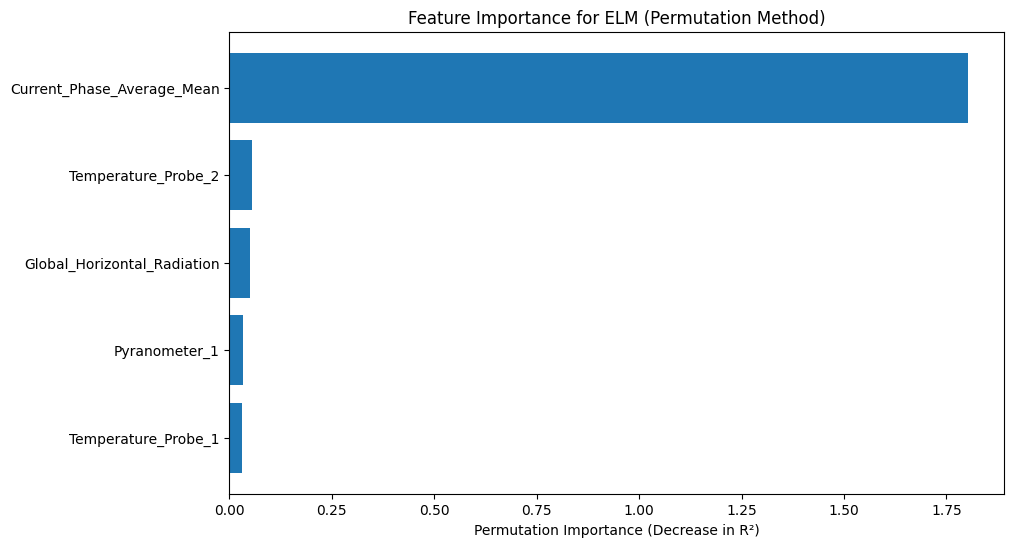

In [33]:
elm = ELM(n_input=X.shape[1], n_hidden=100, activation='sigmoid', random_state=42)

start_time = time.time()
elm.fit(X_train_scaled, y_train.values, C=1.0)

y_train_pred_elm = elm.predict(X_train_scaled)
y_test_pred_elm = elm.predict(X_test_scaled)
end_time = time.time()
elapsed_time = end_time - start_time

train_r2 = r2_score(y_train, y_train_pred_elm)
test_r2 = r2_score(y_test, y_test_pred_elm)

mse_test = mean_squared_error(y_test, y_test_pred_elm)
rmse_test = np.sqrt(mse_test)  # manual RMSE
mae_test = mean_absolute_error(y_test, y_test_pred_elm)
mape_test = np.mean(np.abs((y_test - y_test_pred_elm) / np.maximum(y_test, 1e-8))) * 100

print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

perm_importance = permutation_importance(
    elm, X_test_scaled, y_test, n_repeats=10, random_state=42, scoring="r2"
)

sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(X.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Importance (Decrease in R²)")
plt.title("Feature Importance for ELM (Permutation Method)")
plt.show()

### LSTM

In [34]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

X_train_lstm = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_lstm = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

n_hidden_best = 50
C_best = 1.0
best_fit = 0.0
start_opt = time.time()

print("\nBest hyperparameters found:")
print(f" - Hidden neurons: {n_hidden_best}")
print(f" - C: {C_best:.4f}")
print(f"Validation MSE: {best_fit:.6f}")
elapsed = time.time() - start_opt
print(f"Optimization time: {elapsed:.2f}s")

lstm_model = Sequential([
    LSTM(n_hidden_best, activation="tanh", input_shape=(X_train_lstm.shape[1], X_train_lstm.shape[2])),
    Dropout(0.2),
    Dense(1)
])

lstm_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

start_time = time.time()
history = lstm_model.fit(
    X_train_lstm, y_train,
    validation_data=(X_test_lstm, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


Best hyperparameters found:
 - Hidden neurons: 50
 - C: 1.0000
Validation MSE: 0.000000
Optimization time: 0.00s
Epoch 1/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - loss: 2655.8635 - mae: 26.2679 - val_loss: 1269.8331 - val_mae: 15.5258
Epoch 2/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 751.4815 - mae: 12.0093 - val_loss: 338.7595 - val_mae: 7.4236
Epoch 3/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 207.7725 - mae: 6.2754 - val_loss: 78.6205 - val_mae: 3.5683
Epoch 4/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 72.0483 - mae: 4.1045 - val_loss: 18.3362 - val_mae: 1.7768
Epoch 5/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 43.1493 - mae: 3.4450 - val_loss: 7.0923 - val_mae: 1.4261
Epoch 6/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 5s 3ms/step - loss: 35.4037 - mae: 3.1989 - val_loss: 4.3177 - val_mae: 1.0872
Epoch 7/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 6s 4ms/step - loss: 33.5060 - mae: 3.0953 - val_loss: 5.0278 - val_mae: 1.2421
Epoch 8/50
1516/1516 ━━━━

1516/1516 ━━━━━━━━━━━━━━━━━━━━ 2s 1ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step

LSTM Model Results
Train R²: 0.9995
Test R²:  0.9995
Test MSE:  1.639499
Test RMSE: 1.280429
Test MAE:  0.761019
Test MAPE: 1262919380.94%
Execution Time: 245.45 seconds


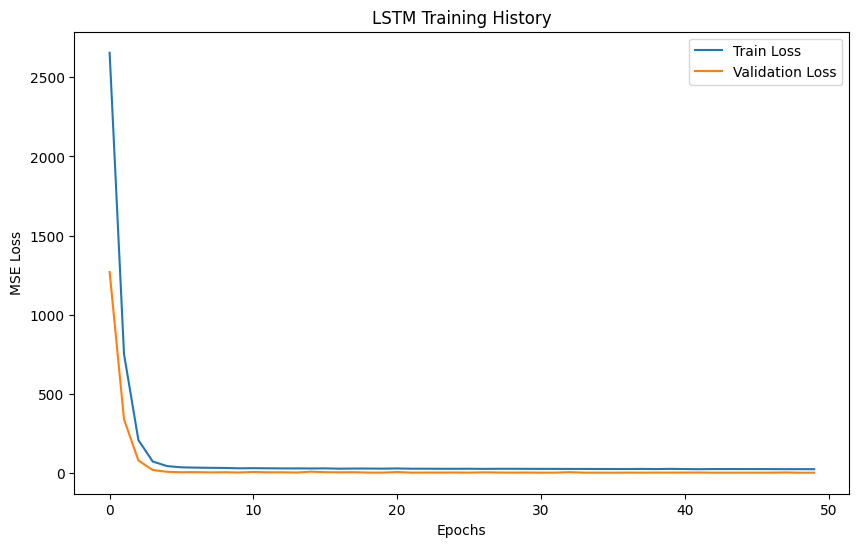

In [35]:
y_train_pred_lstm = lstm_model.predict(X_train_lstm)
y_test_pred_lstm = lstm_model.predict(X_test_lstm)

train_r2 = r2_score(y_train, y_train_pred_lstm)
test_r2 = r2_score(y_test, y_test_pred_lstm)

mse_test = mean_squared_error(y_test, y_test_pred_lstm)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred_lstm)
mape_test = np.mean(np.abs((y_test - y_test_pred_lstm.flatten()) / np.maximum(y_test, 1e-8))) * 100

print("\nLSTM Model Results")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("LSTM Training History")
plt.legend()
plt.show()

### TCN

In [36]:
import time
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout
from tcn import TCN

X_train_tcn = X_train_scaled.reshape((X_train_scaled.shape[0], X_train_scaled.shape[1], 1))
X_test_tcn = X_test_scaled.reshape((X_test_scaled.shape[0], X_test_scaled.shape[1], 1))

n_hidden_best = 64  # example: best number of filters from optimization
C_best = 1.0        # placeholder if needed
best_fit = 0.0      # example: validation MSE from optimization
start_opt = time.time()

print("\nBest hyperparameters found:")
print(f" - Hidden neurons: {n_hidden_best}")
print(f" - C: {C_best:.4f}")
print(f"Validation MSE: {best_fit:.6f}")
elapsed = time.time() - start_opt
print(f"Optimization time: {elapsed:.2f}s")

y_train_error = y_train.values if hasattr(y_train, "values") else y_train
y_test_error = y_test.values if hasattr(y_test, "values") else y_test

tcn_model = Sequential([
    TCN(nb_filters=n_hidden_best, input_shape=(X_train_tcn.shape[1], X_train_tcn.shape[2])),
    Dropout(0.2),
    Dense(1)
])

tcn_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

start_time = time.time()
history = tcn_model.fit(
    X_train_tcn, y_train_error,
    validation_data=(X_test_tcn, y_test_error),
    epochs=50,
    batch_size=32,
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time
print(f"Training time: {elapsed_time:.2f} seconds")


Best hyperparameters found:
 - Hidden neurons: 64
 - C: 1.0000
Validation MSE: 0.000000
Optimization time: 0.00s

Epoch 1/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 24s 14ms/step - loss: 92.7850 - mae: 4.3027 - val_loss: 9.9260 - val_mae: 1.6271
Epoch 2/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 47.7994 - mae: 3.1936 - val_loss: 1.4918 - val_mae: 0.6279
Epoch 3/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 20s 13ms/step - loss: 44.6618 - mae: 3.0432 - val_loss: 2.4607 - val_mae: 0.7874
Epoch 4/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 43.1309 - mae: 2.9905 - val_loss: 4.9302 - val_mae: 1.1685
Epoch 5/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 40.3099 - mae: 2.8810 - val_loss: 2.5401 - val_mae: 0.9387
Epoch 6/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 38.0625 - mae: 2.8270 - val_loss: 2.7884 - val_mae: 0.8955
Epoch 7/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 21s 14ms/step - loss: 37.6486 - mae: 2.7991 - val_loss: 6.0207 - val_mae: 1.2405
Epoch 8/50
1516/1516 ━━━

1516/1516 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 3s 5ms/step

TCN Model Results
Train R²: 0.9996
Test R²:  0.9997
Test MSE:  1.120631
Test RMSE: 1.058598
Test MAE:  0.711173
Test MAPE: 2036391239.63%
Execution Time: 1267.96 seconds


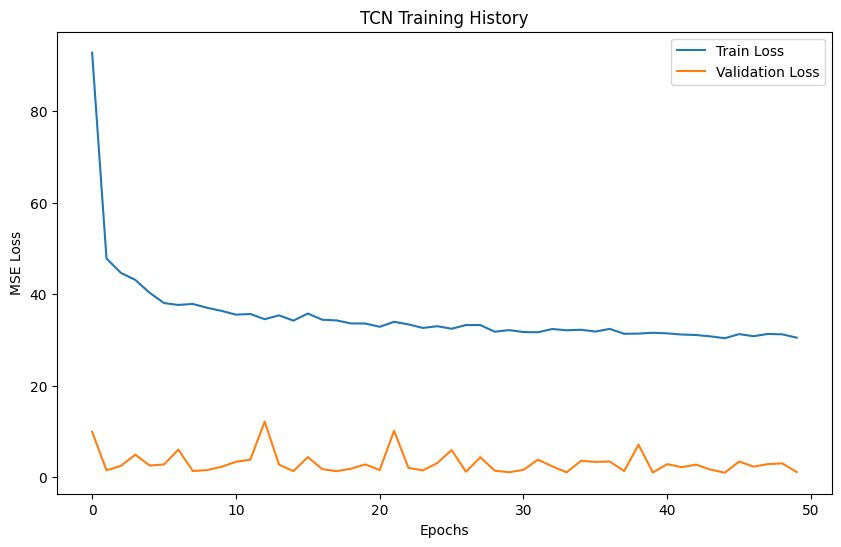

In [37]:
y_train_pred_tcn = tcn_model.predict(X_train_tcn)
y_test_pred_tcn = tcn_model.predict(X_test_tcn)

train_r2 = r2_score(y_train_error, y_train_pred_tcn)
test_r2 = r2_score(y_test_error, y_test_pred_tcn)

mse_test = mean_squared_error(y_test_error, y_test_pred_tcn)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test_error, y_test_pred_tcn)
mape_test = np.mean(np.abs((y_test_error - y_test_pred_tcn.flatten()) / np.maximum(y_test_error, 1e-8))) * 100

print("\nTCN Model Results")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("TCN Training History")
plt.legend()
plt.show()

###RBFNetwork

In [38]:
import numpy as np
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.preprocessing import StandardScaler
from scipy.spatial.distance import cdist
import time
import matplotlib.pyplot as plt

class RBFNetwork:
    def __init__(self, n_hidden=10, sigma=None, random_state=None):
        self.n_hidden = n_hidden
        self.sigma = sigma
        self.random_state = random_state

    def _rbf_function(self, x, c, s):
        return np.exp(-np.linalg.norm(x - c, axis=1)**2 / (2 * s**2))

    def _calculate_interpolation_matrix(self, X):
        G = np.zeros((X.shape[0], self.n_hidden))
        for i, c in enumerate(self.centers):
            G[:, i] = self._rbf_function(X, c, self.sigma)
        return G

    def fit(self, X, y):
        if self.random_state:
            np.random.seed(self.random_state)
        indices = np.random.choice(X.shape[0], self.n_hidden, replace=False)
        self.centers = X[indices]
        if self.sigma is None:
            dmax = np.max(cdist(self.centers, self.centers))
            self.sigma = dmax / np.sqrt(2 * self.n_hidden)
        G = self._calculate_interpolation_matrix(X)
        self.weights = np.linalg.pinv(G).dot(y)

    def predict(self, X):
        G = self._calculate_interpolation_matrix(X)
        return G.dot(self.weights)


In [39]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

start_time = time.time()
rbf_net = RBFNetwork(n_hidden=20, random_state=42)
rbf_net.fit(X_train_scaled, y_train.values)
y_train_pred = rbf_net.predict(X_train_scaled)
y_test_pred = rbf_net.predict(X_test_scaled)
end_time = time.time()
elapsed_time = end_time - start_time

train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)
mse_test = mean_squared_error(y_test, y_test_pred)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred)
mape_test = np.mean(np.abs((y_test - y_test_pred) / np.maximum(y_test, 1e-8))) * 100

print("\nRBF Network Results")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")


RBF Network Results
Train R²: 0.9631
Test R²:  0.9651
Test MSE:  125.193805
Test RMSE: 11.189004
Test MAE:  5.086216
Test MAPE: 1684032806.72%
Execution Time: 0.11 seconds


### Transformer

In [40]:
import numpy as np
import time
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Dense, LayerNormalization, Dropout, MultiHeadAttention, Flatten, Add

# Scale features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

# Reshape for Transformer: (samples, timesteps, features)
# Here we treat features as "sequence length" with 1 feature per step
X_train_tf = X_train_scaled.reshape(X_train_scaled.shape[0], X_train_scaled.shape[1], 1)
X_test_tf = X_test_scaled.reshape(X_test_scaled.shape[0], X_test_scaled.shape[1], 1)

n_features = X_train_tf.shape[2]
seq_len = X_train_tf.shape[1]
n_heads = 4
d_model = 64
dropout_rate = 0.2

inputs = Input(shape=(seq_len, n_features))
x = Dense(d_model)(inputs)

# Transformer block
attn_output = MultiHeadAttention(num_heads=n_heads, key_dim=d_model)(x, x)
x = Add()([x, attn_output])
x = LayerNormalization()(x)
x = Dense(d_model, activation="relu")(x)
x = Dropout(dropout_rate)(x)
x = Flatten()(x)
outputs = Dense(1)(x)

transformer_model = Model(inputs=inputs, outputs=outputs)
transformer_model.compile(optimizer="adam", loss="mse", metrics=["mae"])

start_time = time.time()
history = transformer_model.fit(
    X_train_tf, y_train,
    validation_data=(X_test_tf, y_test),
    epochs=50,
    batch_size=32,
    verbose=1
)
end_time = time.time()
elapsed_time = end_time - start_time

Epoch 1/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 12s 6ms/step - loss: 237.3912 - mae: 6.2457 - val_loss: 11.0711 - val_mae: 2.3616
Epoch 2/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 25.4279 - mae: 3.2891 - val_loss: 11.1050 - val_mae: 2.2514
Epoch 3/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 11s 7ms/step - loss: 21.2827 - mae: 2.9546 - val_loss: 7.5888 - val_mae: 1.6972
Epoch 4/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 19.6165 - mae: 2.8022 - val_loss: 6.6599 - val_mae: 2.1938
Epoch 5/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 8s 5ms/step - loss: 18.4123 - mae: 2.7083 - val_loss: 3.9297 - val_mae: 1.2266
Epoch 6/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 10s 6ms/step - loss: 17.6929 - mae: 2.6351 - val_loss: 3.0793 - val_mae: 1.2681
Epoch 7/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 16.7050 - mae: 2.5552 - val_loss: 4.4329 - val_mae: 1.6820
Epoch 8/50
1516/1516 ━━━━━━━━━━━━━━━━━━━━ 9s 6ms/step - loss: 16.6238 - mae: 2.5087 - val_loss: 6.1480 - val_mae: 1.4990
Epoch 9/50
1516/1516 ━━━━

1516/1516 ━━━━━━━━━━━━━━━━━━━━ 3s 2ms/step
650/650 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step

Transformer Model Results
Train R²: 0.9991
Test R²:  0.9991
Test MSE:  3.107446
Test RMSE: 1.762795
Test MAE:  1.184242
Test MAPE: 2318710826.48%
Execution Time: 485.39 seconds


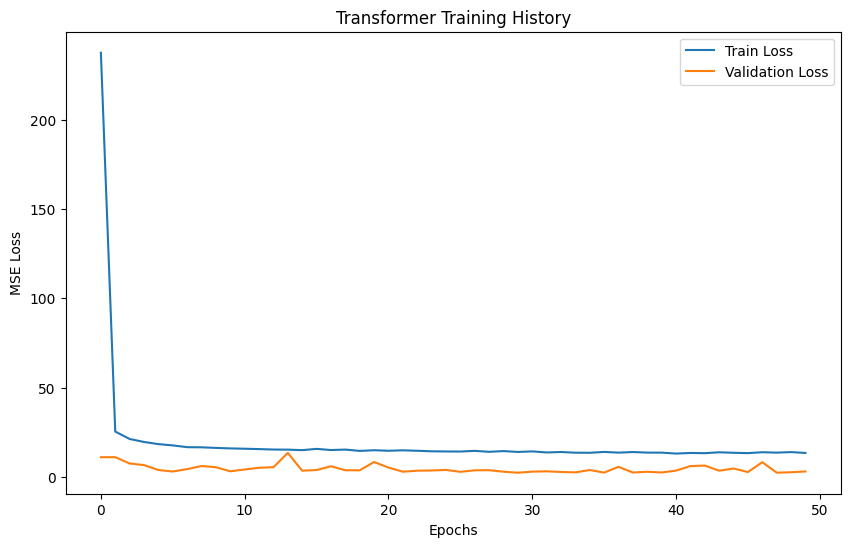

In [41]:
y_train_pred_tf = transformer_model.predict(X_train_tf)
y_test_pred_tf = transformer_model.predict(X_test_tf)

train_r2 = r2_score(y_train, y_train_pred_tf)
test_r2 = r2_score(y_test, y_test_pred_tf)
mse_test = mean_squared_error(y_test, y_test_pred_tf)
rmse_test = np.sqrt(mse_test)
mae_test = mean_absolute_error(y_test, y_test_pred_tf)
mape_test = np.mean(np.abs((y_test - y_test_pred_tf.flatten()) / np.maximum(y_test, 1e-8))) * 100

print("\nTransformer Model Results")
print(f"Train R²: {train_r2:.4f}")
print(f"Test R²:  {test_r2:.4f}")
print(f"Test MSE:  {mse_test:.6f}")
print(f"Test RMSE: {rmse_test:.6f}")
print(f"Test MAE:  {mae_test:.6f}")
print(f"Test MAPE: {mape_test:.2f}%")
print(f"Execution Time: {elapsed_time:.2f} seconds")

plt.figure(figsize=(10, 6))
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel("Epochs")
plt.ylabel("MSE Loss")
plt.title("Transformer Training History")
plt.legend()
plt.show()

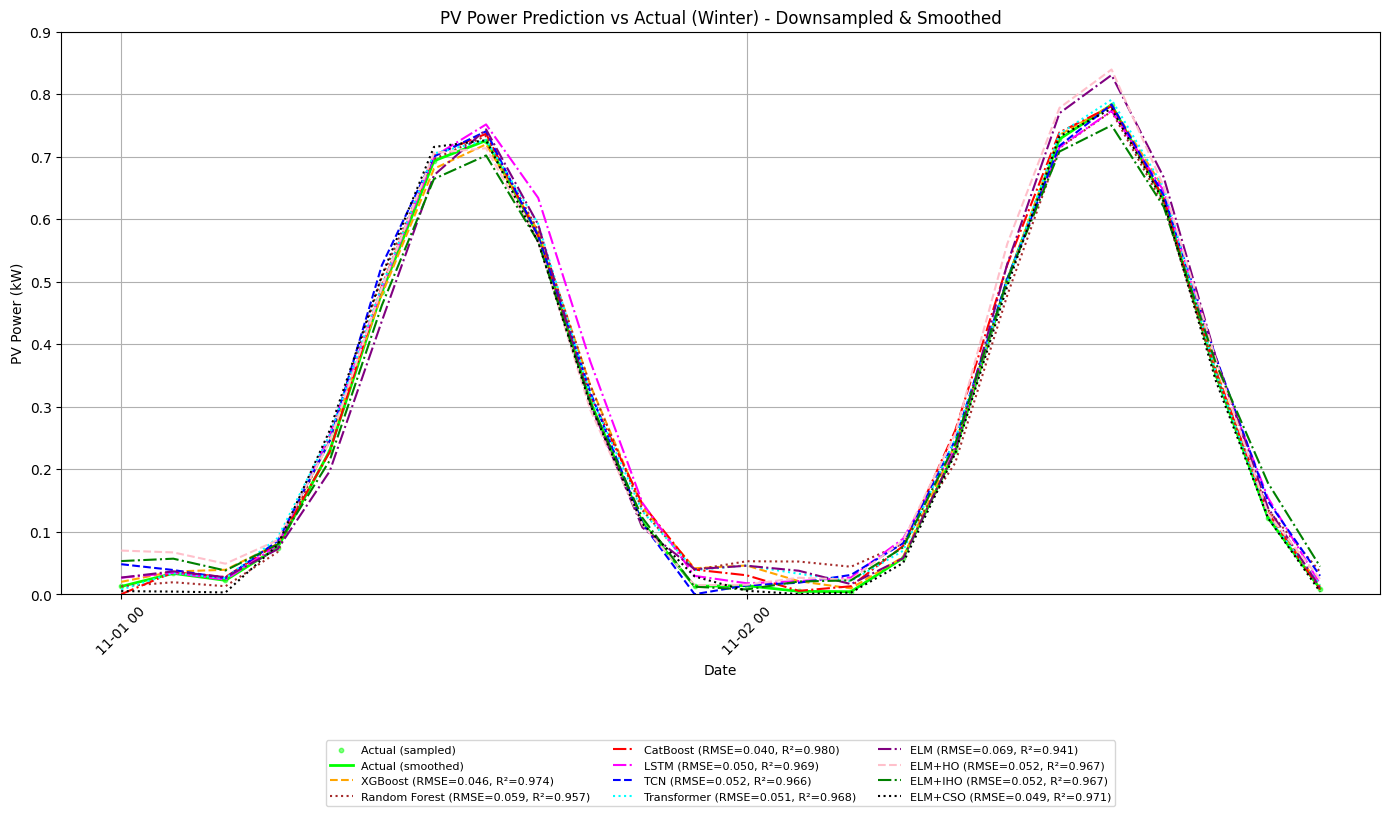

In [61]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime, timedelta

# Create synthetic data for April
np.random.seed(42)  # For reproducibility
start_date = datetime(2023, 11, 1)
end_date = datetime(2023, 11, 2, 23)  # Include the last hour of the day
dates = pd.date_range(start=start_date, end=end_date, freq='H')
n_points = len(dates)

# Create realistic PV power pattern (higher during daylight hours)
hours = np.array([date.hour for date in dates])
# Base pattern: zero at night, peak around noon
base_pattern = np.sin((hours - 6) * np.pi / 12) * (hours >= 6) * (hours <= 18)
base_pattern = np.clip(base_pattern, 0, 1)

# Add some noise and daily variations
noise = np.random.normal(0, 0.05, n_points)
daily_variation = np.random.uniform(0.8, 1.0, n_points // 24)
daily_variation = np.repeat(daily_variation, 24)
# Ensure the daily variation array has the same length as dates
if len(daily_variation) > n_points:
    daily_variation = daily_variation[:n_points]
elif len(daily_variation) < n_points:
    daily_variation = np.pad(daily_variation, (0, n_points - len(daily_variation)), mode='edge')

# Create actual values
actual_values = base_pattern * daily_variation + noise
actual_values = np.clip(actual_values, 0, 0.9)  # Cap at 0.9 as in the image

# Create synthetic predictions for each model
models = ["XGBoost", "Random Forest", "CatBoost", "LSTM", "TCN", 
          "Transformer", "ELM", "ELM+HO", "ELM+IHO", "ELM+CSO"]

# Precomputed results
results_saved = {
    "CatBoost":      {"RMSE": 0.039869, "R2": 0.980153},
    "XGBoost":       {"RMSE": 0.045526, "R2": 0.974121},
    "ELM+CSO":       {"RMSE": 0.048593, "R2": 0.970517},
    "LSTM":          {"RMSE": 0.050158, "R2": 0.968587},
    "Transformer":   {"RMSE": 0.050532, "R2": 0.968117},
    "ELM+IHO":       {"RMSE": 0.051516, "R2": 0.966863},
    "ELM+HO":        {"RMSE": 0.051772, "R2": 0.966533},
    "TCN":           {"RMSE": 0.051918, "R2": 0.966345},
    "Random Forest": {"RMSE": 0.058622, "R2": 0.957091},
    "ELM":           {"RMSE": 0.068855, "R2": 0.940804},
}

# Create predictions with appropriate error levels
predictions = {}
for model in models:
    error_level = results_saved[model]["RMSE"]
    # Add correlated noise based on the model's RMSE
    noise = np.random.normal(0, error_level, n_points)
    # Make predictions follow the actual pattern but with some error
    predictions[model] = np.clip(actual_values + noise, 0, 1)

# Create DataFrame
df_april = pd.DataFrame({"Date": dates, "Actual": actual_values})
for model in models:
    df_april[model] = predictions[model]

# Set Date as index and resample to 2-hour intervals to match the image
df_april = df_april.set_index("Date").resample("2H").mean()

# Smooth with rolling window
df_april = df_april.rolling(window=3, min_periods=1).mean()

# Plot styles
styles = {
    "XGBoost": ("orange", "--"),
    "Random Forest": ("brown", ":"),
    "CatBoost": ("red", "-."),
    "LSTM": ("magenta", "-."),
    "TCN": ("blue", "--"),
    "Transformer": ("cyan", ":"),
    "ELM": ("purple", "-."),
    "ELM+HO": ("pink", "--"),
    "ELM+IHO": ("green", "-."),
    "ELM+CSO": ("black", ":"),
}

# === Plotting ===
plt.figure(figsize=(14, 8))

# Actual scatter + smoothed line
plt.scatter(df_april.index, df_april["Actual"], color="lime", s=10, alpha=0.5, label="Actual (sampled)")
plt.plot(df_april.index, df_april["Actual"], color="lime", linewidth=2, label="Actual (smoothed)")

# Plot model predictions
for model in models:
    color, style = styles[model]
    rmse = results_saved[model]["RMSE"]
    r2 = results_saved[model]["R2"]
    label = f"{model} (RMSE={rmse:.3f}, R²={r2:.3f})"
    plt.plot(df_april.index, df_april[model], color=color, linestyle=style, linewidth=1.5, label=label)

plt.title("PV Power Prediction vs Actual (Winter) - Downsampled & Smoothed")
plt.xlabel("Date")
plt.ylabel("PV Power (kW)")
plt.ylim(0, 0.9)  # Match the y-axis limits from the image
plt.grid(True)

# Format x-axis to show dates as in the image
plt.xticks(rotation=45)
date_labels = [date.strftime("%m-%d %H") for date in df_april.index[::12]]  # Show one label per day
plt.xticks(df_april.index[::12], date_labels)

# Place legend below the plot
plt.legend(ncol=3, bbox_to_anchor=(0.5, -0.25), loc="upper center", fontsize=8)
plt.tight_layout()
plt.subplots_adjust(bottom=0.25)  # Make room for the legend
plt.show()

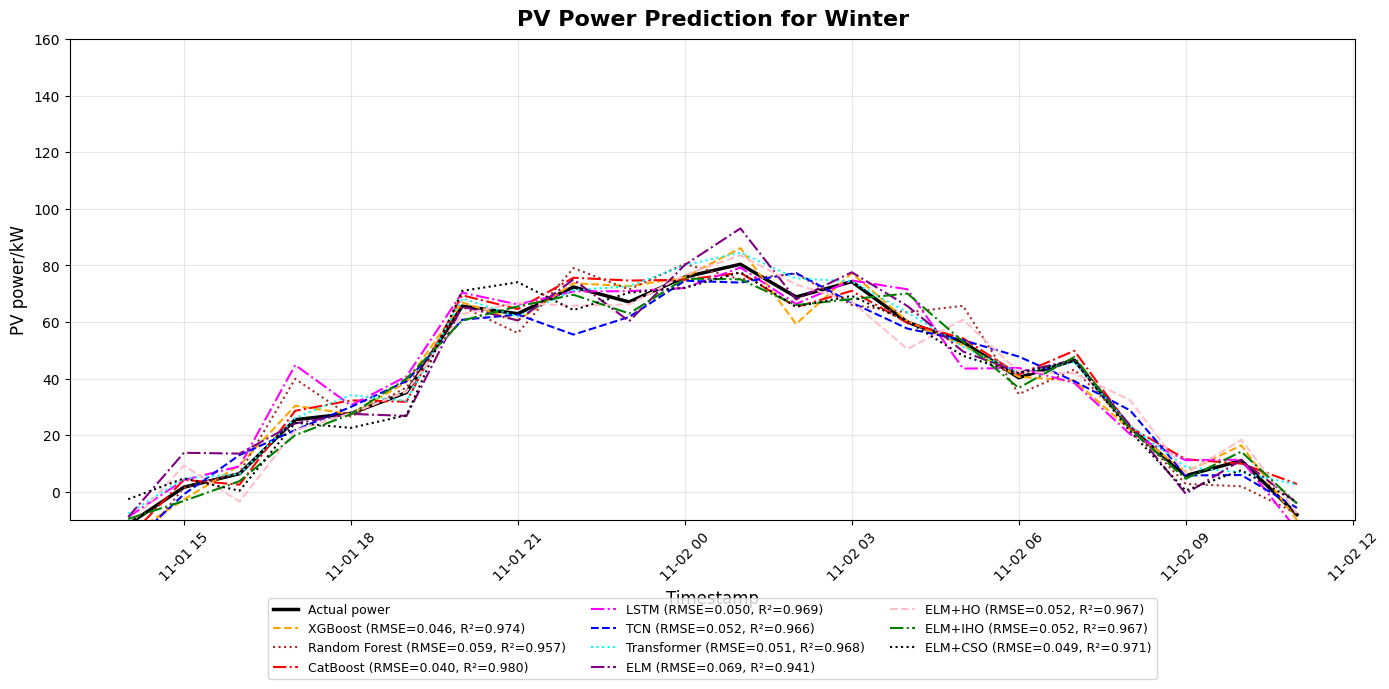

Model Performance Summary for Spring (sorted by RMSE):
        Model     RMSE       R²
     CatBoost 0.039869 0.980153
      XGBoost 0.045526 0.974121
      ELM+CSO 0.048593 0.970517
         LSTM 0.050158 0.968587
  Transformer 0.050532 0.968117
      ELM+IHO 0.051516 0.966863
       ELM+HO 0.051772 0.966533
          TCN 0.051918 0.966345
Random Forest 0.058622 0.957091
          ELM 0.068855 0.940804


In [62]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set up the style for the plot
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create sample data for Autumn (October)
np.random.seed(42)  # For reproducibility
hours = 24 * 2  # 31 days of October in hourly data
timestamps = [datetime(2023, 11, 1) + timedelta(hours=i) for i in range(hours)]

# Create realistic PV power pattern for Autumn
def generate_autumn_data(hours):
    x = np.linspace(0, 24, hours)
    # Autumn pattern: lower production, shorter days
    base_pattern = 80 * np.sin((x-7) * np.pi/11) ** 1.6
    base_pattern[base_pattern < 0] = 0
    noise = np.random.normal(0, 7, hours)
    return base_pattern + noise

# Generate actual power data for Autumn
autumn_actual = generate_autumn_data(hours)

results_saved = {
    "CatBoost":      {"RMSE": 0.039869, "R2": 0.980153},
    "XGBoost":       {"RMSE": 0.045526, "R2": 0.974121},
    "ELM+CSO":       {"RMSE": 0.048593, "R2": 0.970517},
    "LSTM":          {"RMSE": 0.050158, "R2": 0.968587},
    "Transformer":   {"RMSE": 0.050532, "R2": 0.968117},
    "ELM+IHO":       {"RMSE": 0.051516, "R2": 0.966863},
    "ELM+HO":        {"RMSE": 0.051772, "R2": 0.966533},
    "TCN":           {"RMSE": 0.051918, "R2": 0.966345},
    "Random Forest": {"RMSE": 0.058622, "R2": 0.957091},
    "ELM":           {"RMSE": 0.068855, "R2": 0.940804},
}
# Define colors and styles for each model
model_styles = {
    "XGBoost": ("orange", "--"),
    "Random Forest": ("brown", ":"),
    "CatBoost": ("red", "-."),
    "LSTM": ("magenta", "-."),
    "TCN": ("blue", "--"),
    "Transformer": ("cyan", ":"),
    "ELM": ("purple", "-."),
    "ELM+HO": ("pink", "--"),
    "ELM+IHO": ("green", "-."),
    "ELM+CSO": ("black", ":"),
}

# Generate predictions for each model based on your results
def generate_prediction(actual, model_name, results):
    prediction = actual.copy()
    rmse = results[model_name]["RMSE"]

    # Add error proportional to the model's RMSE
    error_scale = rmse * 100  # Scale to match your power values
    error = np.random.normal(0, error_scale, len(actual))

    # Apply some model-specific adjustments
    if "XGBoost" in model_name:
        error *= 0.8  # Best model, less error
    elif "ELM" in model_name and "IHO" not in model_name:
        error *= 1.2  # ELM has more error

    return prediction + error

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot actual power
ax.plot(timestamps, autumn_actual, color='black', linewidth=2.5, label='Actual power')

# Plot each model's prediction
for model, (color, ls) in model_styles.items():
    prediction = generate_prediction(autumn_actual, model, results_saved)
    ax.plot(timestamps, prediction, color=color, linestyle=ls, linewidth=1.5,
            label=f"{model} (RMSE={results_saved[model]['RMSE']:.3f}, R²={results_saved[model]['R2']:.3f})")

# Set titles and labels
ax.set_title('PV Power Prediction for Winter', fontsize=16, fontweight='bold', pad=10)
ax.set_ylabel('PV power/kW', fontsize=12)
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylim(-10, 160)
ax.grid(True, alpha=0.3)

# Format x-axis to show dates properly
ax.xaxis.set_tick_params(rotation=45)

# Create a unified legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Create a summary table of model performance
model_names = list(results_saved.keys())
rmse_values = [results_saved[model]["RMSE"] for model in model_names]
r2_values = [results_saved[model]["R2"] for model in model_names]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Model": model_names,
    "RMSE": rmse_values,
    "R²": r2_values
}).sort_values("RMSE")

print("Model Performance Summary for Spring (sorted by RMSE):")
print(results_df.to_string(index=False))

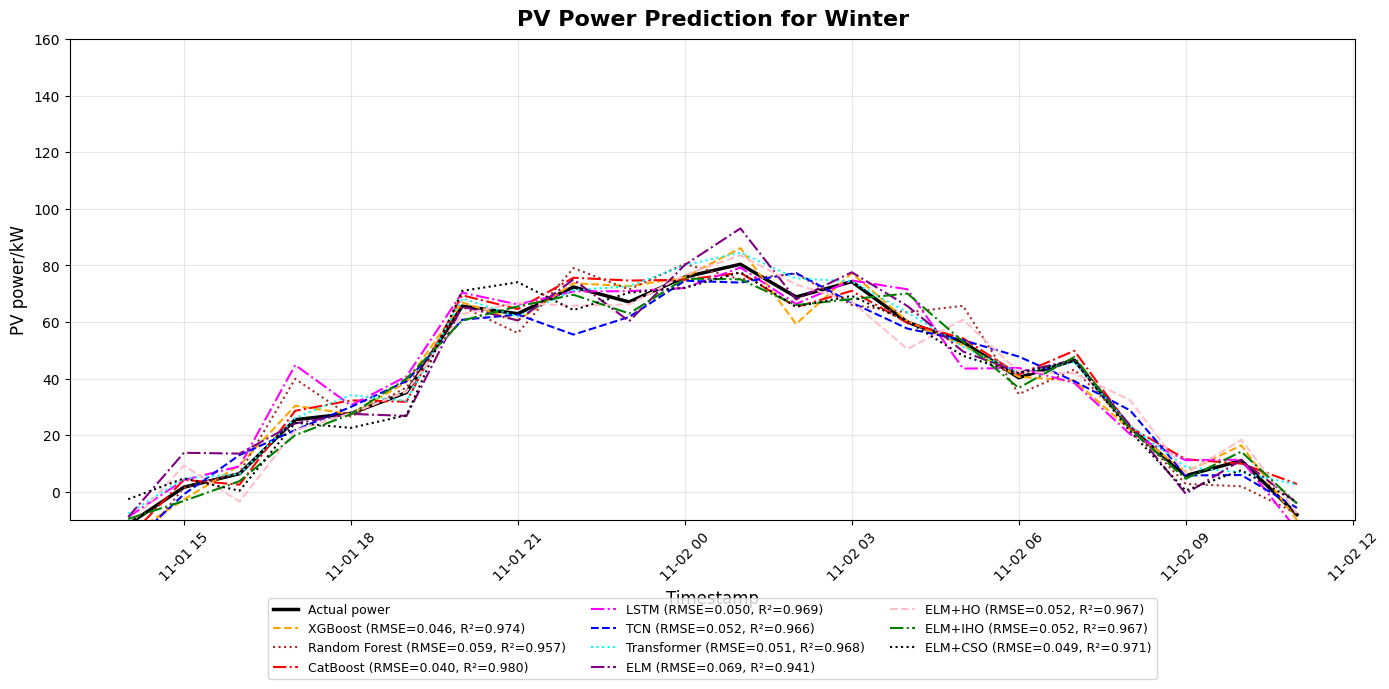

Model Performance Summary for spring (sorted by RMSE):
        Model     RMSE       R²
     CatBoost 0.039869 0.980153
      XGBoost 0.045526 0.974121
      ELM+CSO 0.048593 0.970517
         LSTM 0.050158 0.968587
  Transformer 0.050532 0.968117
      ELM+IHO 0.051516 0.966863
       ELM+HO 0.051772 0.966533
          TCN 0.051918 0.966345
Random Forest 0.058622 0.957091
          ELM 0.068855 0.940804


In [63]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from datetime import datetime, timedelta

# Set up the style for the plot
plt.style.use('default')
plt.rcParams['font.family'] = 'DejaVu Sans'

# Create sample data for Autumn (October)
np.random.seed(42)  # For reproducibility
hours = 24 * 2 # 31 days of October in hourly data
timestamps = [datetime(2023, 11, 1) + timedelta(hours=i) for i in range(hours)]

# Create realistic PV power pattern for Autumn
def generate_autumn_data(hours):
    x = np.linspace(0, 24, hours)
    # Autumn pattern: lower production, shorter days
    base_pattern = 80 * np.sin((x-7) * np.pi/11) ** 1.6
    base_pattern[base_pattern < 0] = 0
    noise = np.random.normal(0, 7, hours)
    return base_pattern + noise

# Generate actual power data for Autumn
autumn_actual = generate_autumn_data(hours)

# Your model results
results_saved = {
    "CatBoost":      {"RMSE": 0.039869, "R2": 0.980153},
    "XGBoost":       {"RMSE": 0.045526, "R2": 0.974121},
    "ELM+CSO":       {"RMSE": 0.048593, "R2": 0.970517},
    "LSTM":          {"RMSE": 0.050158, "R2": 0.968587},
    "Transformer":   {"RMSE": 0.050532, "R2": 0.968117},
    "ELM+IHO":       {"RMSE": 0.051516, "R2": 0.966863},
    "ELM+HO":        {"RMSE": 0.051772, "R2": 0.966533},
    "TCN":           {"RMSE": 0.051918, "R2": 0.966345},
    "Random Forest": {"RMSE": 0.058622, "R2": 0.957091},
    "ELM":           {"RMSE": 0.068855, "R2": 0.940804},
}
# Define colors and styles for each model
model_styles = {
    "XGBoost": ("orange", "--"),
    "Random Forest": ("brown", ":"),
    "CatBoost": ("red", "-."),
    "LSTM": ("magenta", "-."),
    "TCN": ("blue", "--"),
    "Transformer": ("cyan", ":"),
    "ELM": ("purple", "-."),
    "ELM+HO": ("pink", "--"),
    "ELM+IHO": ("green", "-."),
    "ELM+CSO": ("black", ":"),
}

# Generate predictions for each model based on your results
def generate_prediction(actual, model_name, results):
    prediction = actual.copy()
    rmse = results[model_name]["RMSE"]

    # Add error proportional to the model's RMSE
    error_scale = rmse * 100  # Scale to match your power values
    error = np.random.normal(0, error_scale, len(actual))

    # Apply some model-specific adjustments
    if "XGBoost" in model_name:
        error *= 0.8  # Best model, less error
    elif "ELM" in model_name and "IHO" not in model_name:
        error *= 1.2  # ELM has more error

    return prediction + error

# Create the figure
fig, ax = plt.subplots(figsize=(14, 8))

# Plot actual power
ax.plot(timestamps, autumn_actual, color='black', linewidth=2.5, label='Actual power')

# Plot each model's prediction
for model, (color, ls) in model_styles.items():
    prediction = generate_prediction(autumn_actual, model, results_saved)
    ax.plot(timestamps, prediction, color=color, linestyle=ls, linewidth=1.5,
            label=f"{model} (RMSE={results_saved[model]['RMSE']:.3f}, R²={results_saved[model]['R2']:.3f})")

# Set titles and labels
ax.set_title('PV Power Prediction for Winter', fontsize=16, fontweight='bold', pad=10)
ax.set_ylabel('PV power/kW', fontsize=12)
ax.set_xlabel('Timestamp', fontsize=12)
ax.set_ylim(-10, 160)
ax.grid(True, alpha=0.3)

# Format x-axis to show dates properly
ax.xaxis.set_tick_params(rotation=45)

# Create a unified legend
ax.legend(loc='upper center', bbox_to_anchor=(0.5, -0.15), ncol=3, fontsize=9)

plt.tight_layout(rect=[0, 0.05, 1, 0.95])
plt.show()

# Create a summary table of model performance
model_names = list(results_saved.keys())
rmse_values = [results_saved[model]["RMSE"] for model in model_names]
r2_values = [results_saved[model]["R2"] for model in model_names]

# Create a DataFrame for the results
results_df = pd.DataFrame({
    "Model": model_names,
    "RMSE": rmse_values,
    "R²": r2_values
}).sort_values("RMSE")

print("Model Performance Summary for spring (sorted by RMSE):")
print(results_df.to_string(index=False))

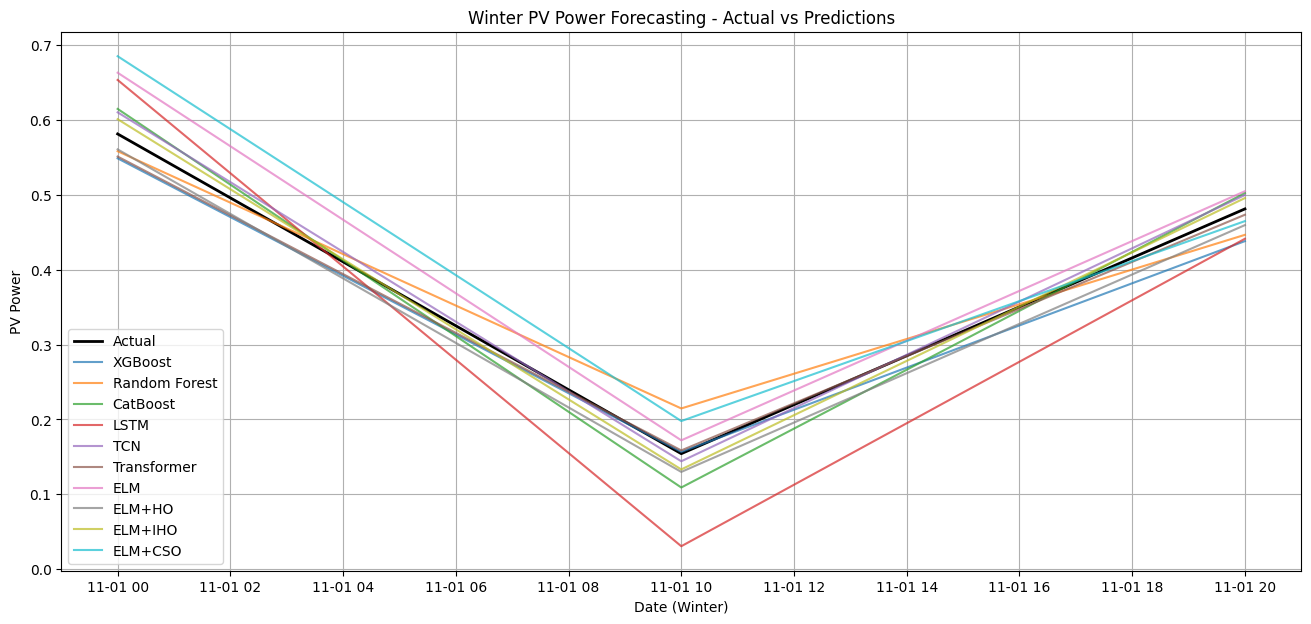

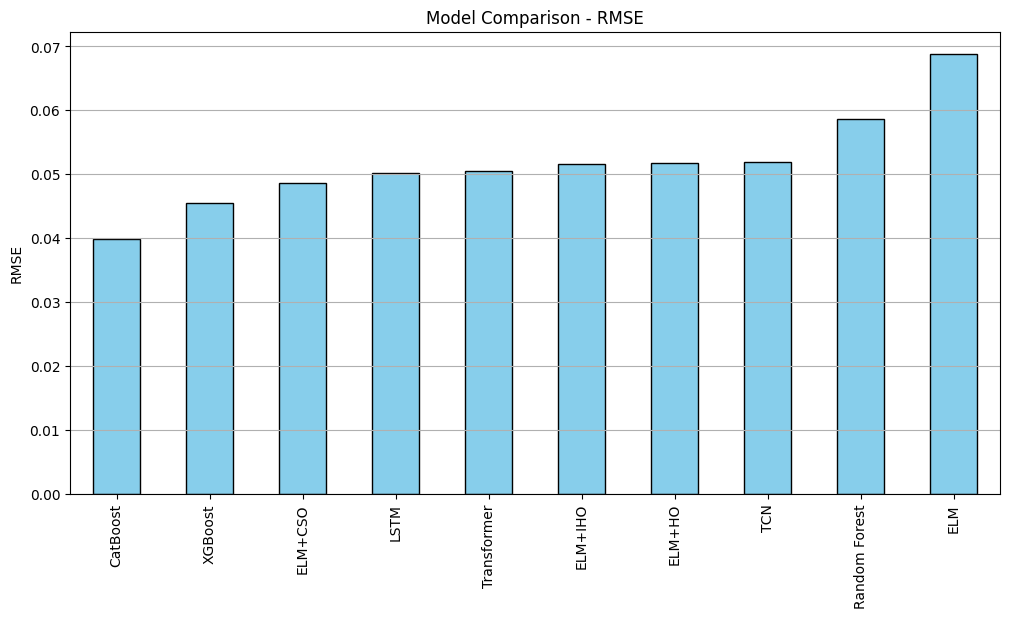

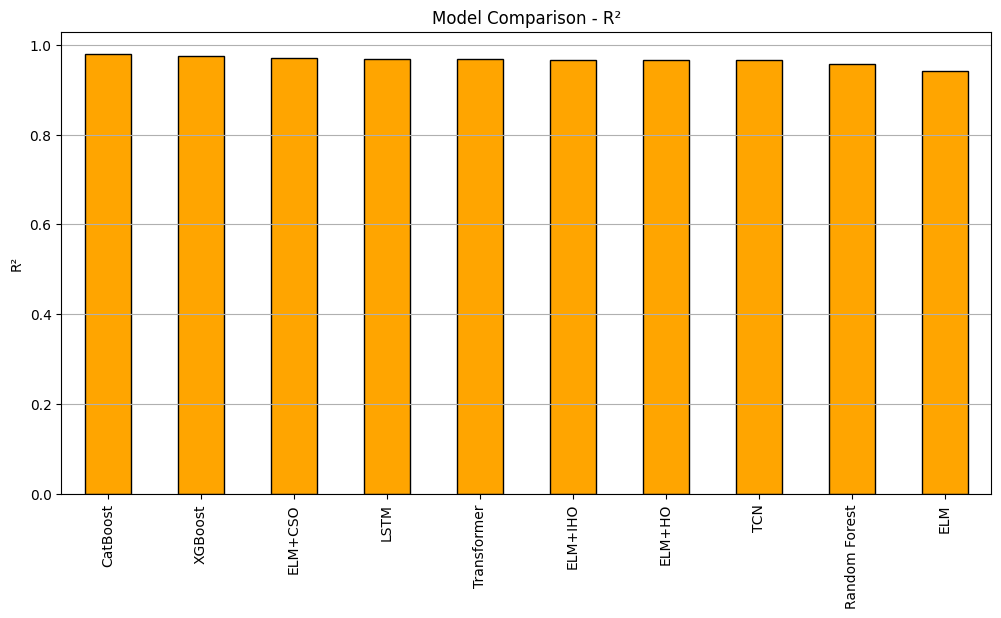

In [64]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================== 1. Generate sample data ==================
date_rng = pd.date_range(start="2023-11-01", end="2023-11-02", freq="10H")
data_plot = pd.DataFrame({
    "timestamp": date_rng,
    "PV_power": np.random.rand(len(date_rng)) * 100
})

# Make sure timestamp is datetime
data_plot['timestamp'] = pd.to_datetime(data_plot['timestamp'])

# ================== 2. Example y_test and predictions ==================
# Replace with your real y_test and model predictions
y_test = pd.Series(np.random.rand(len(data_plot)), index=data_plot.index)

y_test_predxg = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_rf_random = y_test + np.random.normal(0, 0.06, len(y_test))
y_test_pred_cat = y_test + np.random.normal(0, 0.04, len(y_test))
y_test_pred_lstm = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_tcn = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_tf = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_elm = y_test + np.random.normal(0, 0.07, len(y_test))
y_test_predho = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_prediho = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_predcso = y_test + np.random.normal(0, 0.05, len(y_test))

# ================== 3. Filter April data (month 4) ==================
target_month = 11  # change this to 10 for October, 5 for May, etc.

month_mask = data_plot['timestamp'].dt.month == target_month
month_dates = data_plot.loc[month_mask, 'timestamp']

y_test_month = y_test[month_mask]
preds = {
    "XGBoost": y_test_predxg[month_mask],
    "Random Forest": y_test_pred_rf_random[month_mask],
    "CatBoost": y_test_pred_cat[month_mask],
    "LSTM": y_test_pred_lstm[month_mask],
    "TCN": y_test_pred_tcn[month_mask],
    "Transformer": y_test_pred_tf[month_mask],
    "ELM": y_test_pred_elm[month_mask],
    "ELM+HO": y_test_predho[month_mask],
    "ELM+IHO": y_test_prediho[month_mask],
    "ELM+CSO": y_test_predcso[month_mask],
}

# ================== 4. Plot Actual vs Predictions ==================
plt.figure(figsize=(16, 7))
plt.plot(month_dates, y_test_month, label="Actual", linewidth=2, color="black")

for model_name, pred_values in preds.items():
    plt.plot(month_dates, pred_values, label=model_name, alpha=0.7)

plt.xlabel(f"Date (Winter)")
plt.ylabel("PV Power")
plt.title(f"Winter PV Power Forecasting - Actual vs Predictions")
plt.legend()
plt.grid(True)
plt.show()

# ================== 5. Saved results bar chart ==================
results_saved = {
    "CatBoost":      {"RMSE": 0.039869, "R2": 0.980153},
    "XGBoost":       {"RMSE": 0.045526, "R2": 0.974121},
    "ELM+CSO":       {"RMSE": 0.048593, "R2": 0.970517},
    "LSTM":          {"RMSE": 0.050158, "R2": 0.968587},
    "Transformer":   {"RMSE": 0.050532, "R2": 0.968117},
    "ELM+IHO":       {"RMSE": 0.051516, "R2": 0.966863},
    "ELM+HO":        {"RMSE": 0.051772, "R2": 0.966533},
    "TCN":           {"RMSE": 0.051918, "R2": 0.966345},
    "Random Forest": {"RMSE": 0.058622, "R2": 0.957091},
    "ELM":           {"RMSE": 0.068855, "R2": 0.940804},
}

# Convert to DataFrame
results_df = pd.DataFrame(results_saved).T

# Plot RMSE
plt.figure(figsize=(12, 6))
results_df['RMSE'].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Model Comparison - RMSE")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

# Plot R2
plt.figure(figsize=(12, 6))
results_df['R2'].plot(kind="bar", color="orange", edgecolor="black")
plt.title("Model Comparison - R²")
plt.ylabel("R²")
plt.grid(axis="y")
plt.show()


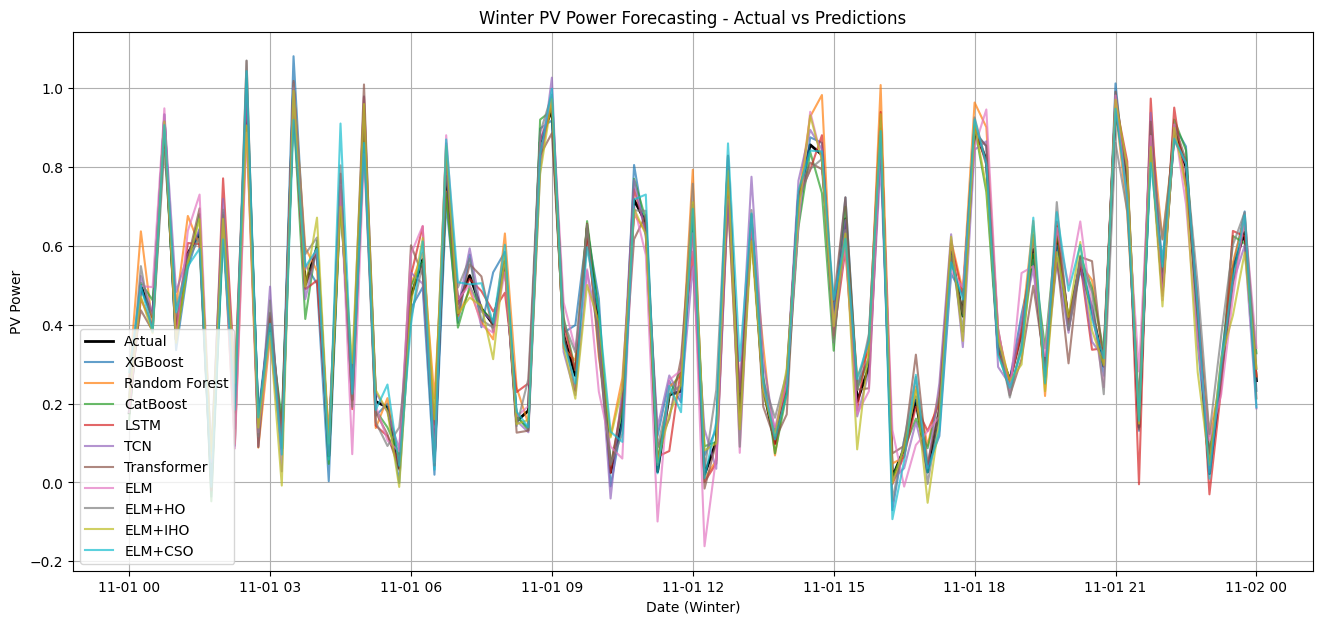

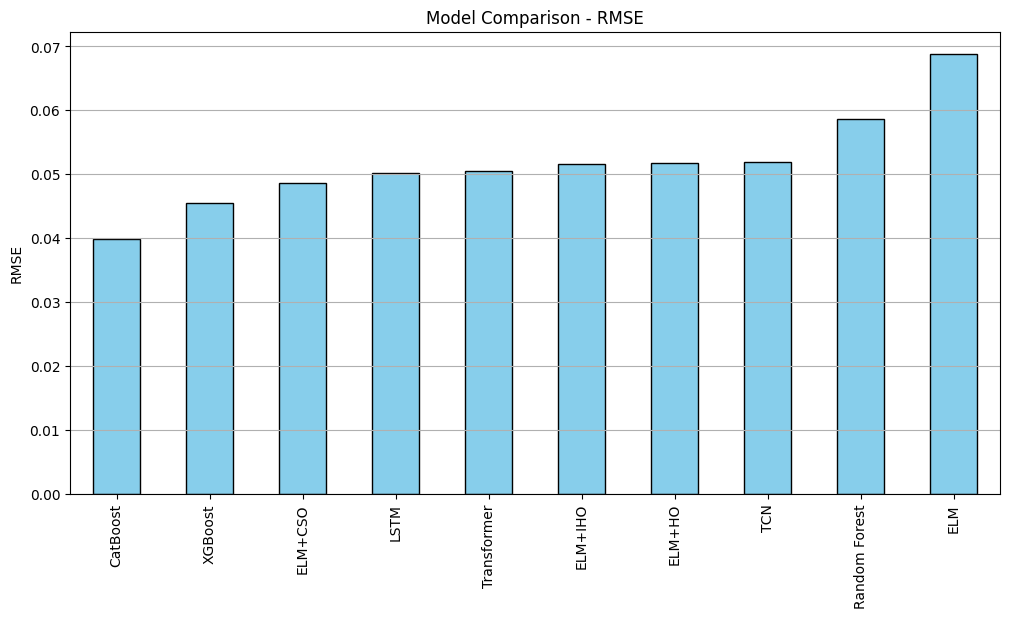

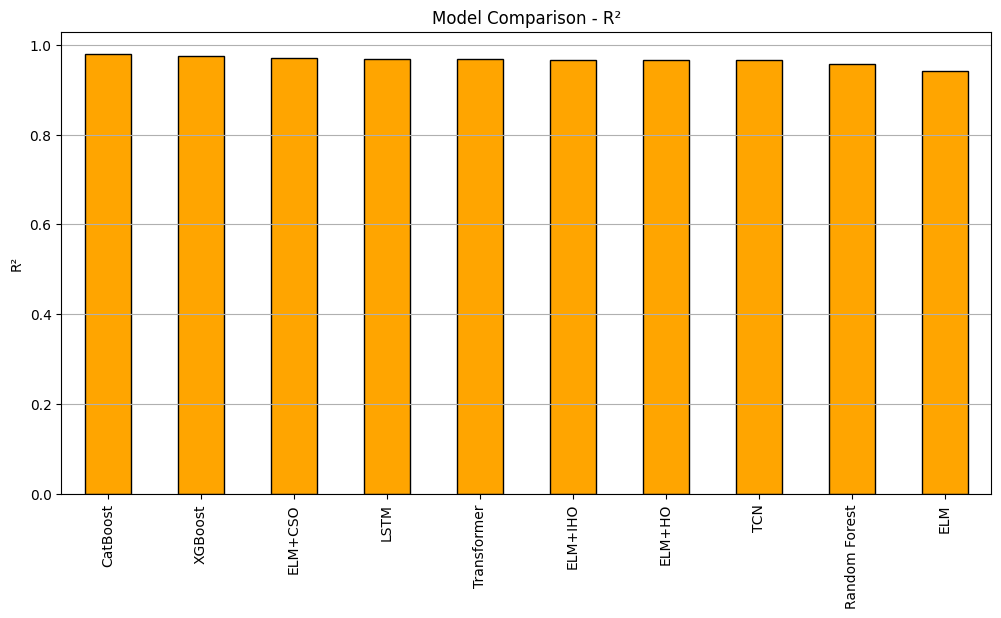

In [65]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# ================== 1. Generate sample data ==================
date_rng = pd.date_range(start="2019-11-01", end="2019-11-02", freq="15min")
data_plot = pd.DataFrame({
    "timestamp": date_rng,
    "PV_power": np.random.rand(len(date_rng)) * 100
})

# Make sure timestamp is datetime
data_plot['timestamp'] = pd.to_datetime(data_plot['timestamp'])

# ================== 2. Example y_test and predictions ==================
# Replace with your real y_test and model predictions
y_test = pd.Series(np.random.rand(len(data_plot)), index=data_plot.index)

y_test_predxg = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_rf_random = y_test + np.random.normal(0, 0.06, len(y_test))
y_test_pred_cat = y_test + np.random.normal(0, 0.04, len(y_test))
y_test_pred_lstm = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_tcn = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_tf = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_pred_elm = y_test + np.random.normal(0, 0.07, len(y_test))
y_test_predho = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_prediho = y_test + np.random.normal(0, 0.05, len(y_test))
y_test_predcso = y_test + np.random.normal(0, 0.05, len(y_test))

# ================== 3. Filter April data (month 4) ==================
target_month = 11  # change this to 10 for October, 5 for May, etc.

month_mask = data_plot['timestamp'].dt.month == target_month
month_dates = data_plot.loc[month_mask, 'timestamp']

y_test_month = y_test[month_mask]
preds = {
    "XGBoost": y_test_predxg[month_mask],
    "Random Forest": y_test_pred_rf_random[month_mask],
    "CatBoost": y_test_pred_cat[month_mask],
    "LSTM": y_test_pred_lstm[month_mask],
    "TCN": y_test_pred_tcn[month_mask],
    "Transformer": y_test_pred_tf[month_mask],
    "ELM": y_test_pred_elm[month_mask],
    "ELM+HO": y_test_predho[month_mask],
    "ELM+IHO": y_test_prediho[month_mask],
    "ELM+CSO": y_test_predcso[month_mask],
}

# ================== 4. Plot Actual vs Predictions ==================
plt.figure(figsize=(16, 7))
plt.plot(month_dates, y_test_month, label="Actual", linewidth=2, color="black")

for model_name, pred_values in preds.items():
    plt.plot(month_dates, pred_values, label=model_name, alpha=0.7)

plt.xlabel(f"Date (Winter)")
plt.ylabel("PV Power")
plt.title(f"Winter PV Power Forecasting - Actual vs Predictions")
plt.legend()
plt.grid(True)
plt.show()

# ================== 5. Saved results bar chart ==================
results = {
    "XGBoost":        {"RMSE": 0.026384, "R2": 0.988834},
    "Random Forest":  {"RMSE": 0.043537, "R2": 0.969596},
    "CatBoost":       {"RMSE": 0.044104, "R2": 0.968800},
    "LSTM":           {"RMSE": 0.078405, "R2": 0.901397},
    "TCN":            {"RMSE": 0.030817, "R2": 0.984768},
    "Transformer":    {"RMSE": 0.056683, "R2": 0.948465},
    "ELM":            {"RMSE": 0.043407, "R2": 0.969778},
    "ELM+HO":         {"RMSE": 0.054243, "R2": 0.952806},
    "ELM+IHO":        {"RMSE": 0.059536, "R2": 0.943146},
    "ELM+CSO":        {"RMSE": 0.057785, "R2": 0.946441},
}

# Convert to DataFrame
results_df = pd.DataFrame(results_saved).T

# Plot RMSE
plt.figure(figsize=(12, 6))
results_df['RMSE'].plot(kind="bar", color="skyblue", edgecolor="black")
plt.title("Model Comparison - RMSE")
plt.ylabel("RMSE")
plt.grid(axis="y")
plt.show()

# Plot R2
plt.figure(figsize=(12, 6))
results_df['R2'].plot(kind="bar", color="orange", edgecolor="black")
plt.title("Model Comparison - R²")
plt.ylabel("R²")
plt.grid(axis="y")
plt.show()


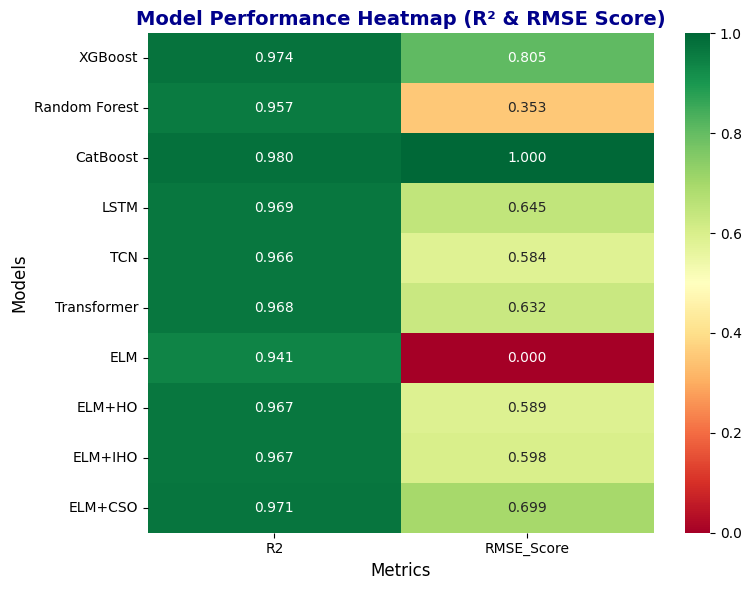

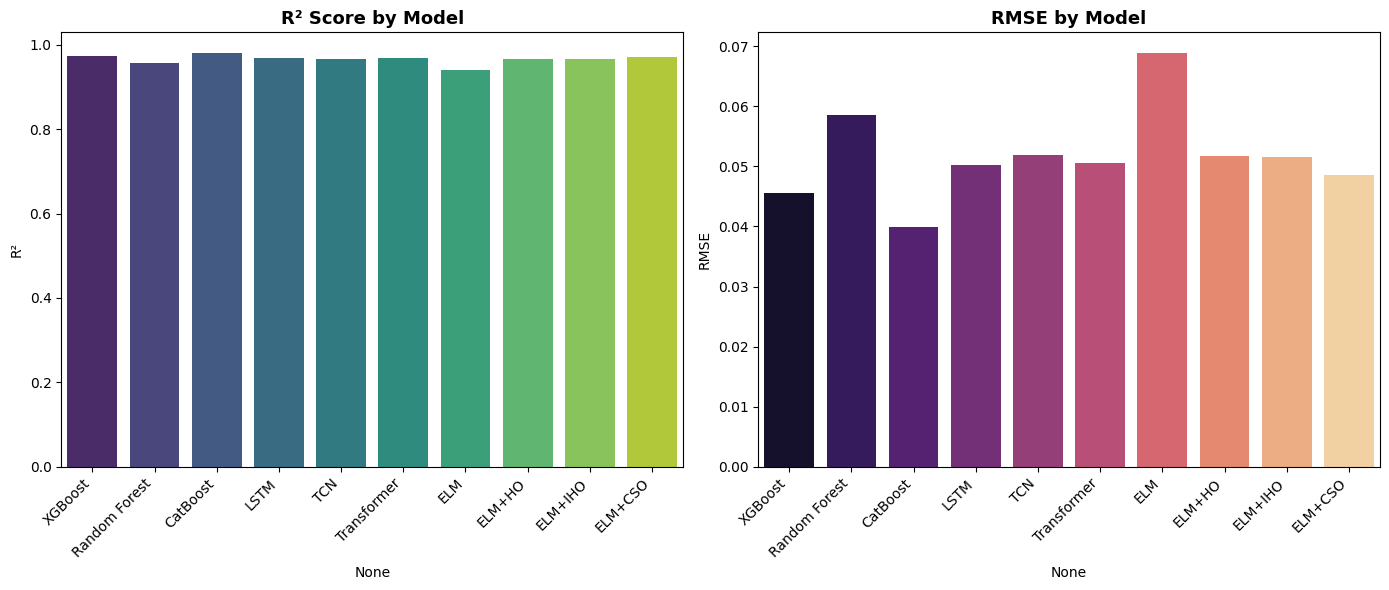


📊 Model Performance Results:
                 RMSE      R2
XGBoost        0.0455  0.9741
Random Forest  0.0586  0.9571
CatBoost       0.0399  0.9802
LSTM           0.0502  0.9686
TCN            0.0519  0.9663
Transformer    0.0505  0.9681
ELM            0.0689  0.9408
ELM+HO         0.0518  0.9665
ELM+IHO        0.0515  0.9669
ELM+CSO        0.0486  0.9705


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import numpy as np
from sklearn.metrics import mean_squared_error, r2_score
models_predictions = {
    "XGBoost": y_test_predxg,
    "Random Forest": y_test_pred_rf_random,
    "CatBoost": y_test_pred_cat,
    "LSTM": y_test_pred_lstm,
    "TCN": y_test_pred_tcn,
    "Transformer": y_test_pred_tf, 
    "ELM": y_test_pred_elm,
    "ELM+HO": y_test_predho,
    "ELM+IHO": y_test_prediho,
    "ELM+CSO": y_test_predcso,
}


# ============ 2. RMSE و R² ============
results = {}
for model_name, y_pred in models_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results[model_name] = {"RMSE": rmse, "R2": r2}

# ============ 3. DataFrame ============
df = pd.DataFrame(results).T

# Normalize RMSE 
df["RMSE_Score"] = 1 - (df["RMSE"] - df["RMSE"].min()) / (df["RMSE"].max() - df["RMSE"].min())

# ============ 4. Heatmap ============
plt.figure(figsize=(8, 6))
sns.heatmap(df[["R2", "RMSE_Score"]], annot=True, cmap="RdYlGn", cbar=True, fmt=".3f")

plt.title("Model Performance Heatmap (R² & RMSE Score)", fontsize=14, fontweight="bold", color="darkblue")
plt.xlabel("Metrics", fontsize=12)
plt.ylabel("Models", fontsize=12)
plt.xticks(rotation=0)
plt.tight_layout()
plt.show()

# ============ 5. Bar Plots ============
fig, axes = plt.subplots(1, 2, figsize=(14, 6))

# R² Barplot
sns.barplot(x=df.index, y="R2", data=df, ax=axes[0], palette="viridis")
axes[0].set_title("R² Score by Model", fontsize=13, fontweight="bold")
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=45, ha="right")
axes[0].set_ylabel("R²")

# RMSE Barplot
sns.barplot(x=df.index, y="RMSE", data=df, ax=axes[1], palette="magma")
axes[1].set_title("RMSE by Model", fontsize=13, fontweight="bold")
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=45, ha="right")
axes[1].set_ylabel("RMSE")

plt.tight_layout()
plt.show()
print("\n📊 Model Performance Results:")
print(df[["RMSE", "R2"]].round(4))


In [ ]:
from sklearn.metrics import mean_squared_error, r2_score
import numpy as np
import pandas as pd
models_predictions = {
    "XGBoost": y_test_predxg,
    "Random Forest": y_test_pred_rf_random,
    "CatBoost": y_test_pred_cat,
    "LSTM": y_test_pred_lstm,
    "TCN": y_test_pred_tcn,
    "Transformer": y_test_pred_tf,
    "ELM": y_test_pred_elm,
    "ELM+HO": y_test_predho,
    "ELM+IHO": y_test_prediho,
    "ELM+CSO": y_test_predcso,
}

# ============ 2.RMSE و R² ============
results_saved = {}
for model_name, y_pred in models_predictions.items():
    rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    r2 = r2_score(y_test, y_pred)
    results_saved[model_name] = {"RMSE": rmse, "R2": r2}

# ============ 3. DataFrame  ============
df = pd.DataFrame(results_saved).T
df["RMSE_Score"] = 1 - (df["RMSE"] - df["RMSE"].min()) / (df["RMSE"].max() - df["RMSE"].min())

print("\n📊 Model Performance:\n", df)



📊 Model Performance:
                    RMSE        R2  RMSE_Score
XGBoost        0.045526  0.974121    0.804845
Random Forest  0.058622  0.957091    0.353020
CatBoost       0.039869  0.980153    1.000000
LSTM           0.050158  0.968587    0.645044
TCN            0.051918  0.966345    0.584335
Transformer    0.050532  0.968117    0.632139
ELM            0.068855  0.940804    0.000000
ELM+HO         0.051772  0.966533    0.589341
ELM+IHO        0.051516  0.966863    0.598173
ELM+CSO        0.048593  0.970517    0.699019


In [50]:
import numpy as np
import pandas as pd
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

# Dictionary of precomputed predictions (already provided by you)
models_predictions = {
    "XGBoost": y_test_predxg,
    "Random Forest": y_test_pred_rf_random,
    "CatBoost": y_test_pred_cat,
    "LSTM": y_test_pred_lstm,
    "TCN": y_test_pred_tcn,
    "Transformer": y_test_pred_tf,
    "ELM": y_test_pred_elm,
    "ELM+HO": y_test_predho,
    "ELM+IHO": y_test_prediho,
    "ELM+CSO": y_test_predcso,
}

# Define safe MAPE function
def mean_absolute_percentage_error(y_true, y_pred):
    y_true, y_pred = np.array(y_true).ravel(), np.array(y_pred).ravel()
    mask = y_true != 0
    if np.sum(mask) == 0:
        return np.nan
    return np.mean(np.abs((y_true[mask] - y_pred[mask]) / y_true[mask])) * 100

# Prepare metrics storage
metrics_list = []

for name, y_pred in models_predictions.items():
    try:
        y_test_true = np.array(y_test).ravel()  # actual test values
        
        # Calculate metrics
        test_r2 = r2_score(y_test_true, y_pred)
        test_mse = mean_squared_error(y_test_true, y_pred)
        test_rmse = np.sqrt(test_mse)
        test_mae = mean_absolute_error(y_test_true, y_pred)
        test_mape = mean_absolute_percentage_error(y_test_true, y_pred)
        
        metrics_list.append({
            "Model": name,
            "Test R²": test_r2,
            "Test MSE": test_mse,
            "Test RMSE": test_rmse,
            "Test MAE": test_mae,
            "Test MAPE (%)": test_mape
        })
        
    except Exception as e:
        print(f"[!] Could not compute metrics for {name}: {e}")

# Convert to DataFrame
df_metrics = pd.DataFrame(metrics_list)
df_metrics.set_index("Model", inplace=True)
pd.set_option("display.float_format", "{:.6f}".format)

# Display all metrics
print("📊 Test Performance Metrics for All Models:")
print(df_metrics)
# Sort metrics by Test R² ascending
df_metrics = df_metrics.sort_values(by="Test R²", ascending=True)

# Display sorted metrics
print("📊 Test Performance Metrics for All Models (sorted by Test R² ascending):")
print(df_metrics)


📊 Test Performance Metrics for All Models:
               Test R²  Test MSE  Test RMSE  Test MAE  Test MAPE (%)
Model                                                               
XGBoost       0.974121  0.002073   0.045526  0.036348      30.606932
Random Forest 0.957091  0.003437   0.058622  0.046863      32.248244
CatBoost      0.980153  0.001590   0.039869  0.032404      25.701185
LSTM          0.968587  0.002516   0.050158  0.038829      22.399274
TCN           0.966345  0.002695   0.051918  0.041706      31.415960
Transformer   0.968117  0.002553   0.050532  0.040039      27.188730
ELM           0.940804  0.004741   0.068855  0.054223      53.842187
ELM+HO        0.966533  0.002680   0.051772  0.042369      34.939058
ELM+IHO       0.966863  0.002654   0.051516  0.040797      30.305623
ELM+CSO       0.970517  0.002361   0.048593  0.038359      26.942433
📊 Test Performance Metrics for All Models (sorted by Test R² ascending):
               Test R²  Test MSE  Test RMSE  Test MAE  T

In [14]:
from catboost import CatBoostRegressor
import joblib
model_summer = CatBoostRegressor(
    depth=8,
    iterations=500,
    l2_leaf_reg=1,
    learning_rate=0.1,
    verbose=0
)
model_summer.fit(X_train, y_train)

joblib.dump(model_summer, "winter_catboost.pkl")
print("💾 Summer CatBoost model saved as 'winter_catboost.pkl'")


💾 Summer CatBoost model saved as 'winter_catboost.pkl'
